# Forecast COVID-19 in USA (state-level)

## 설정

실험에 사용할 라이브러리 (전체 환경은 requirement.txt 확인)

In [4]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import json
import os
from tqdm import tqdm

실험에서 생성된 파일들을 저장할 디렉토리 지정 (data, model, image)

In [5]:
data_path = './data/'
model_path = './saved/'
image_path = './images/'

## 탐색적 데이터 분석(EDA)

### 구글 COVID-19 오픈데이터

- 출처: https://github.com/GoogleCloudPlatform/covid-19-open-data (github)
- index: 데이터를 구별할 수 있는 primary key 알려주는 테이블
- epidemology: 확진자, 사망자, 회복자, 검사자 (일일 및 누적) 데이터를 담고있는 테이블
- google-trends: COVID 증상과 관련된 쿼리 검색 비율
- us_adjacent_states.json: 미국의 각 주의 이름과 해당 주와 인접한 주 목록을 포함한 파일 (개인 제작)

아래 데이터는 구글 오픈 데이터에서 미국(contry_code=='US')의 정보만 편집한 것

In [6]:
index = pd.read_csv(data_path + 'us_index.csv')
epidemic = pd.read_csv(data_path + 'us_epidemiology.csv')
trends = pd.read_csv(data_path + 'us_google-search_trends.csv')
states = json.load(open(data_path + 'us_adjacent_states.json', 'r'))

In [7]:
#다운로드 받은 전세계 코로나 google trend 데이터를 미국 주 데이터로 전처리
'''
us_google_search_trends = None
chunksize = 10 ** 6

#파일이 커서 청크 단위로 잘라서 처리
state_codes = [get_region_code(state_name) for state_name in states.keys()]
with pd.read_csv(data_path + 'google-search-trends.csv', chunksize=chunksize) as reader:
    for chunk in tqdm(reader):
        if us_google_search_trends is None:
            us_google_search_trends = pd.DataFrame(columns=chunk.columns)
        #end if
        
        us_google_search_trends = pd.concat([
            us_google_search_trends, 
            chunk[chunk['location_key'].isin(state_codes)]
        ])
    #end for
#end with

#저장
us_google_search_trends = us_google_search_trends.reset_index(drop=True)
us_google_search_trends = us_google_search_trends.rename(columns={'location_key' : 'key'})
us_google_search_trends.to_csv(data_path + 'us_google-search_trends.csv', index=False)
'''

"\nus_google_search_trends = None\nchunksize = 10 ** 6\n\n#파일이 커서 청크 단위로 잘라서 처리\nstate_codes = [get_region_code(state_name) for state_name in states.keys()]\nwith pd.read_csv(data_path + 'google-search-trends.csv', chunksize=chunksize) as reader:\n    for chunk in tqdm(reader):\n        if us_google_search_trends is None:\n            us_google_search_trends = pd.DataFrame(columns=chunk.columns)\n        #end if\n        \n        us_google_search_trends = pd.concat([\n            us_google_search_trends, \n            chunk[chunk['location_key'].isin(state_codes)]\n        ])\n    #end for\n#end with\n\n#저장\nus_google_search_trends = us_google_search_trends.reset_index(drop=True)\nus_google_search_trends = us_google_search_trends.rename(columns={'location_key' : 'key'})\nus_google_search_trends.to_csv(data_path + 'us_google-search_trends.csv', index=False)\n"

In [8]:
#다운로드 받은 전세계 코로나 데이터 를 미국 주 데이터로 전처리

'''
state_codes = [get_region_code(state_name) for state_name in states.keys()]
epidemic_temp = pd.read_csv(data_path + 'epidemiology.csv')
epidemic_temp = epidemic_temp[epidemic_temp['location_key'].isin(state_codes)].reset_index(drop=True)
epidemic_temp = epidemic_temp.rename(columns={'location_key' : 'key'})
epidemic_temp.to_csv(data_path + 'us_epidemiology.csv', index=False)
'''

"\nstate_codes = [get_region_code(state_name) for state_name in states.keys()]\nepidemic_temp = pd.read_csv(data_path + 'epidemiology.csv')\nepidemic_temp = epidemic_temp[epidemic_temp['location_key'].isin(state_codes)].reset_index(drop=True)\nepidemic_temp = epidemic_temp.rename(columns={'location_key' : 'key'})\nepidemic_temp.to_csv(data_path + 'us_epidemiology.csv', index=False)\n"

#### index table

state-level로 예측할 것이기 때문에,

- key: 다른 테이블에서 참조할 수 있는 고유한 key 값
- subregion1_name: 해당 주의 이름

두 컬럼을 사용해 key 값을 찾고 다른 테이블에 적용할 예정

In [9]:
index

key wikidata  datacommons country_code  \
0              US      Q30  country/USA           US   
1           US_AK     Q797     geoId/02           US   
2     US_AK_02013  Q504371  geoId/02013           US   
3     US_AK_02016  Q185533  geoId/02016           US   
4     US_AK_02020   Q39450  geoId/02020           US   
...           ...      ...          ...          ...   
3280  US_WY_56037  Q484194  geoId/56037           US   
3281  US_WY_56039  Q488912  geoId/56039           US   
3282  US_WY_56041  Q483973  geoId/56041           US   
3283  US_WY_56043  Q112846  geoId/56043           US   
3284  US_WY_56045  Q115413  geoId/56045           US   

                  country_name subregion1_code subregion1_name  \
0     United States of America             NaN             NaN   
1     United States of America              AK          Alaska   
2     United States of America              AK          Alaska   
3     United States of America              AK          Alaska   
4     United States of America              AK          Alaska   
...                        ...             ...             ...   
3280  United States of America              WY         Wyoming   
3281  United States of America              WY         Wyoming   
3282  United States of America              WY         Wyoming   
3283  United States of America              WY         Wyoming   
3284  United States of America              WY         Wyoming   

      subregion2_code         subregion2_name locality_code locality_name  \
0                 NaN                     NaN           NaN           NaN   
1                 NaN                     NaN           NaN           NaN   
2              2013.0          Aleutians East           NaN           NaN   
3              2016.0          Aleutians West           NaN           NaN   
4              2020.0  Anchorage Municipality           NaN           NaN   
...               ...                     ...           ...           ...   
3280          56037.0       Sweetwater County           NaN           NaN   
3281          56039.0            Teton County           NaN           NaN   
3282          56041.0            Uinta County           NaN           NaN   
3283          56043.0         Washakie County           NaN           NaN   
3284          56045.0           Weston County           NaN           NaN   

     3166-1-alpha-2 3166-1-alpha-3  aggregation_level  
0                US            USA                  0  
1                US            USA                  1  
2                US            USA                  2  
3                US            USA                  2  
4                US            USA                  2  
...             ...            ...                ...  
3280             US            USA                  2  
3281             US            USA                  2  
3282             US            USA                  2  
3283             US            USA                  2  
3284             US            USA                  2  

[3285 rows x 14 columns]

#### epidemology table

- date: 데이터가 발생한 날짜
- key: index 테이블에서 가져오는 데이터를 구별하는 고유 key
- new_confirmed: 신규 확진자
- new_deceased: 신규 사망자
- new_recorvered: 신규 회복자
- new_tested: 신규 검사자
- total_...: 신규 데이터를 누적한 결과

In [10]:
epidemic

date    key  new_confirmed  new_deceased  new_recovered  \
0      2020-01-22  US_AL            0.0           0.0            NaN   
1      2020-01-23  US_AL            0.0           0.0            NaN   
2      2020-01-24  US_AL            0.0           0.0            NaN   
3      2020-01-25  US_AL            0.0           0.0            NaN   
4      2020-01-26  US_AL            0.0           0.0            NaN   
...           ...    ...            ...           ...            ...   
42053  2022-06-11  US_WY            0.0           0.0            NaN   
42054  2022-06-12  US_WY            0.0           0.0            NaN   
42055  2022-06-13  US_WY            0.0           0.0            NaN   
42056  2022-06-14  US_WY         2453.0           0.0            NaN   
42057  2022-06-15  US_WY            0.0           0.0            NaN   

       new_tested  cumulative_confirmed  cumulative_deceased  \
0             NaN                   0.0                  0.0   
1             NaN                   0.0                  0.0   
2             NaN                   0.0                  0.0   
3             NaN                   0.0                  0.0   
4             NaN                   0.0                  0.0   
...           ...                   ...                  ...   
42053         NaN              159707.0               1824.0   
42054         NaN              159707.0               1824.0   
42055         NaN              159707.0               1824.0   
42056         NaN              162160.0               1824.0   
42057         NaN              162160.0               1824.0   

       cumulative_recovered  cumulative_tested  
0                       NaN                NaN  
1                       NaN                NaN  
2                       NaN                NaN  
3                       NaN                NaN  
4                       NaN                NaN  
...                     ...                ...  
42053                   NaN                NaN  
42054                   NaN                NaN  
42055                   NaN                NaN  
42056                   NaN                NaN  
42057                   NaN                NaN  

[42058 rows x 10 columns]

#### google-trend table

- date: query 검색이 발생한 날짜
- key: 구별 가능한 고유 key
- search_trends_*symptom*: *symptom* query의 검색 비율 (전체 기간 중 가장 높은 시점을 100으로 두고 나머지 비율을 환산)

In [11]:
trends

date    key  search_trends_abdominal_obesity  \
0      2020-01-01  US_AL                             2.86   
1      2020-01-02  US_AL                             2.69   
2      2020-01-03  US_AL                             2.45   
3      2020-01-04  US_AL                             2.48   
4      2020-01-05  US_AL                             2.81   
...           ...    ...                              ...   
35083  2021-12-27  US_WY                             1.71   
35084  2021-12-28  US_WY                             1.71   
35085  2021-12-29  US_WY                             1.71   
35086  2021-12-30  US_WY                             1.37   
35087  2021-12-31  US_WY                             1.13   

       search_trends_abdominal_pain  search_trends_acne  \
0                              5.05                8.63   
1                              5.27                9.36   
2                              5.12                9.12   
3                              5.19                9.61   
4                              5.12                9.26   
...                             ...                 ...   
35083                          4.26                6.29   
35084                          4.85                6.28   
35085                          4.61                6.71   
35086                          4.42                6.51   
35087                          4.21                4.47   

       search_trends_actinic_keratosis  search_trends_acute_bronchitis  \
0                                 0.30                            0.88   
1                                 0.36                            0.92   
2                                 0.33                            0.93   
3                                 0.31                            0.82   
4                                 0.41                            0.81   
...                                ...                             ...   
35083                              NaN                            0.78   
35084                              NaN                            0.91   
35085                              NaN                            0.49   
35086                             0.54                            0.81   
35087                              NaN                            0.60   

       search_trends_adrenal_crisis  search_trends_ageusia  \
0                              0.10                    NaN   
1                              0.14                   0.07   
2                              0.13                    NaN   
3                              0.08                   0.07   
4                              0.12                    NaN   
...                             ...                    ...   
35083                           NaN                    NaN   
35084                           NaN                    NaN   
35085                           NaN                    NaN   
35086                           NaN                    NaN   
35087                           NaN                    NaN   

       search_trends_alcoholism  ...  search_trends_visual_acuity  \
0                          5.04  ...                         0.46   
1                          4.39  ...                         0.36   
2                          4.15  ...                         0.34   
3                          4.00  ...                         0.24   
4                          3.91  ...                         0.26   
...                         ...  ...                          ...   
35083                      4.27  ...                          NaN   
35084                      3.79  ...                          NaN   
35085                      4.23  ...                          NaN   
35086                      4.14  ...                          NaN   
35087                      5.13  ...                          NaN   

       search_trends_vomiting  search_trends_wart  \
0                        3.91                1.32   
1 

### 누락 데이터 처리

NaN으로 누락된 부분은 이전 값으로 채움, 이전 값이 없는 경우 0

In [12]:
epidemic = epidemic.fillna(method='ffill')
epidemic = epidemic.fillna(0)
trends = trends.fillna(method='ffill')
trends = trends.fillna(0)

### 편의성 함수

#### 지역 이름 <> 코드 변환 함수

In [13]:
# name > code
def get_region_code(region_name, index=index):
    ''' 지역 이름을 코드로 변환하는 함수
    Args:
      region_name (str): 지역의 이름 ex) New York

    Returns:
      region_code (str): 지역의 코드 ex) US_NY
    '''
    if region_name == 'US':
        return region_name

    region_code = index[(index['subregion1_name'] == region_name) &
                      (index['aggregation_level'] == 1)]['key'].values[0]
    return region_code


# code > name
def get_region_name(region_code, index=index):
    ''' 지역 코드를 이름으로 변환하는 함수
    Args:
      region_code (str): 지역의 코드

    Returns:
      region_name (str): 지역의 이름
    '''
    if region_code == 'US':
        return region_code

    country_code, subregion_code = region_code.split('_')
    region_name = index[(index['country_code'] == country_code) &
                      (index['subregion1_code'] == subregion_code)]['subregion1_name'].values[0]
    return region_name

#### 특정 지역의 데이터 반환하는 함수

- state: 지역 이름(string)
- data_df: 타겟 데이터 테이블(DataFrame)
- cols: 얻고자 하는 데이터 종류 이름(string > seriese 반환, list > dataframe 반환)
- accumulate: 데이터의 누적 여부(bool)

In [14]:
def get_state_data(state, data_df, cols='new_confirmed', acc=False):
    ''' 지역의 데이터를 불러오는 함수
    Args:
      state (str): 지역의 이름
      data_df (pandas.DataFrame): 전체 데이터 테이블(프레임)
      cols (str, list): 불러올 데이터 테이블의 컬럼명, str형태일 경우 series반환, list형태일 경우 dataframe반환
      acc (bool): 누적 데이터로 만들어서 불러올 것인지 여부 (확진자 데이터의 경우 누적 데이터가 있으나, 웹의 경우 없음)

    Returns:
      padas.Series / pandas.DataFrame: 해당 지역의 데이터(cols의 타입 및 acc에 따라 리턴 타입이 다름)
    '''
    region_code = get_region_code(state)
    if acc:
        return np.add.accumulate(data_df[data_df['key']==region_code][cols].reset_index(drop=True))
    else:
        return data_df[data_df['key']==region_code][cols].reset_index(drop=True)

### 사용가능한 데이터 범위 분석

각 데이터의 시작 및 종료 날짜를 확인

In [15]:
date_analysis = pd.DataFrame(columns=['epidemic_start', 'epidemic_end',
                                      'trends_start', 'trends_end'])

for state in states:
    region_code = get_region_code(state)
    date_analysis = pd.concat([
      date_analysis, 
      pd.DataFrame({'epidemic_start': epidemic[epidemic['key'] == region_code][:1]['date'].values,
                    'epidemic_end': epidemic[epidemic['key'] == region_code][-1:]['date'].values,
                    'trends_start': trends[trends['key'] == region_code][:1]['date'].values,
                    'trends_end': trends[trends['key'] == region_code][-1:]['date'].values,},
                   index=[state])])

date_analysis

epidemic_start epidemic_end trends_start  trends_end
Washington               2020-01-13   2022-06-15   2020-01-01  2021-12-31
Illinois                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
California               2020-01-22   2022-06-15   2020-01-01  2021-12-31
Arizona                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
Massachusetts            2020-01-22   2022-06-15   2020-01-01  2021-12-31
Wisconsin                2020-01-22   2022-06-15   2020-01-01  2021-12-31
Texas                    2020-01-22   2022-06-15   2020-01-01  2021-12-31
Nebraska                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Utah                     2020-01-22   2022-06-15   2020-01-01  2021-12-31
Oregon                   2020-01-22   2022-06-15   2020-01-01  2021-12-31
Florida                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
New York                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Rhode Island             2020-01-22   2022-06-15   2020-01-01  2021-12-31
Georgia                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
New Hampshire            2020-01-22   2022-06-15   2020-01-01  2021-12-31
North Carolina           2020-01-22   2022-06-15   2020-01-01  2021-12-31
New Jersey               2020-01-22   2022-06-15   2020-01-01  2021-12-31
Colorado                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Maryland                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Nevada                   2020-01-22   2022-06-15   2020-01-01  2021-12-31
Tennessee                2020-01-22   2022-06-15   2020-01-01  2021-12-31
Indiana                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
Kentucky                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Minnesota                2020-01-22   2022-06-15   2020-01-01  2021-12-31
Oklahoma                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Pennsylvania             2020-01-22   2022-06-15   2020-01-01  2021-12-31
South Carolina           2020-01-22   2022-06-15   2020-01-01  2021-12-31
District of Columbia     2020-01-22   2022-12-30   2020-01-01  2021-12-31
Kansas                   2020-01-22   2022-06-15   2020-01-01  2021-12-31
Missouri                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Vermont                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
Virginia                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Connecticut              2020-01-22   2022-06-15   2020-01-01  2021-12-31
Iowa                     2020-01-22   2022-06-15   2020-01-01  2021-12-31
Louisiana                2020-01-22   2022-06-15   2020-01-01  2021-12-31
Ohio                     2020-01-22   2022-06-15   2020-01-01  2021-12-31
Michigan                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
South Dakota             2020-01-22   2022-06-15   2020-01-01  2021-12-31
Arkansas                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Delaware                 2020-01-22   2022-06-15   2020-01-01  2021-12-31
Mississippi              2020-01-22   2022-06-15   2020-01-01  2021-12-31
New Mexico               2020-01-22   2022-06-15   2020-01-01  2021-12-31
North Dakota             2020-01-22   2022-06-15   2020-01-01  2021-12-31
Wyoming                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
Maine                    2020-01-22   2022-06-15   2020-01-01  2021-12-31
Alabama                  2020-01-22   2022-06-15   2020-01-01  2021-12-31
Idaho                    2020-01-22   2022-06-15   2020-01-01  2021-12-31
Montana                  2020-01-22   2022-06-15   2020-01-01  2021-12-31

1) epidemic 데이터 사용 가능 구간은 [20.01.22 ~ 21.04.15]
2) trends 데이터 사용 가능 구간은 [20.01.01 ~ 21.04.11]

3월부터 미국에 코로나가 본격적으로 발생한 것을 기반으로 

[20.03.01 ~ 21.04.11] 로 기간 설정

In [16]:
selected_dates = []
start_date = datetime(2020, 3, 1)
while(start_date <= datetime(2021, 12, 31)):
    selected_dates.append(start_date.strftime('%Y-%m-%d'))
    start_date += timedelta(1)
epidemic = epidemic[epidemic['date'].isin(selected_dates)]
trends = trends[trends['date'].isin(selected_dates)]

### 데이터 시각화 및 분석

#### COVID case

##### 전체 데이터 확인

1) 많은 지역에서 큰 2개의 피크를 찾을 수 있었음(1차: 20.06 부근, 2차: 20.12 부근)
2) Massachusetts, Georgia, Missouri, Iowa 지역에서 아주 큰 이상값 발견

In [17]:
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
for i, state in enumerate(states):
    scaler = MinMaxScaler()
    p1, = axs[i//7][i%7].plot(scaler.fit_transform(get_state_data(state, epidemic, cols=['new_confirmed']).values))
    xticks = np.arange(100, len(selected_dates), 100)
    axs[i//7][i%7].set_title(state)
    axs[i//7][i%7].set_xticks(xticks)
    axs[i//7][i%7].set_xticklabels([selected_dates[i][2:].replace('-', '') for i in xticks],
                                 rotation=45)
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.close(fig)

<AxesSubplot:>

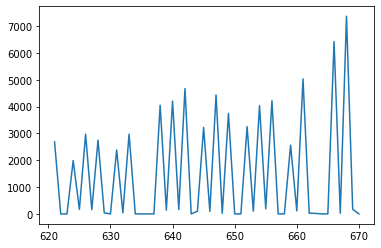

In [18]:
get_state_data('Kansas', epidemic)[-50:].plot()

##### 중앙값, 이상값 확인 (확진자)

1) California, Texas, Florida, New York 는 다른 지역에 비해 확진자 수가 많은 편
2) Massachusetts에는 음수를 갖는 값들이 존재
3) Missouri는 중앙값에 비해 너무 큰 이상값 존재

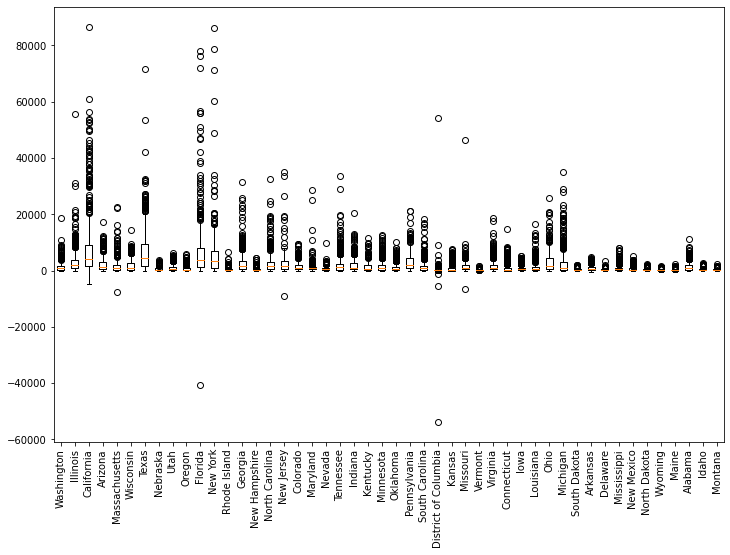

In [19]:
fig = plt.figure(figsize=(12, 8))
box_data = []
for state in states:
    state_data = get_state_data(state, epidemic).values
    box_data.append(state_data)
box_analysis = plt.boxplot(box_data, whis=1.5)
plt.xticks(np.arange(1, len(states)+1), list(states), rotation=90)
plt.show()
plt.close(fig)

##### 이상값 조정

갑작스러운 증가는 발생할 수 있지만, 음수 및 공휴일에 발생하는 0은 결측값이라고 판단, 0이하의값은 7일 이동평균으로 조정

그러나 아직 Kansas, Iowa 등 관측값 자체가 불안정하게 급변하는 지역이 있음

In [20]:
for state in tqdm(states):
    tmp_df = get_state_data(state, epidemic, ['date', 'new_confirmed'])
    roll_df = tmp_df.rolling(7).mean()

    dates = tmp_df[tmp_df['new_confirmed'] <= 0]['date']
    indices = tmp_df[tmp_df['new_confirmed'] <= 0].index

    for i, date in enumerate(dates):
        idx = epidemic[(epidemic['key']==get_region_code(state)) &
                       (epidemic['date']==date)].index
        roll_val = roll_df.loc[indices[i], 'new_confirmed']
        roll_val = 0 if np.isnan(roll_val) else roll_val
        epidemic.loc[idx, 'new_confirmed'] = roll_val

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.64it/s]


## 데이터 보간
- 7일 단위로 끊어서 데이터를 보간한다.

In [21]:
interpolated_epidemic = pd.DataFrame(columns=epidemic.columns[:3])
interpolated_epidemic

for state in tqdm(states):
    df = epidemic[epidemic['key'] == get_region_code(state)][['date', 'key', 'new_confirmed']]
    df = df.reset_index(drop=True)
    
    df.loc[df.index % 7 != 0, df.columns[2:]] = None
    df['new_confirmed'] = pd.Series(df['new_confirmed']).interpolate(method='linear')
    
    interpolated_epidemic = pd.concat([interpolated_epidemic, df])
#end for

interpolated_epidemic = interpolated_epidemic.reset_index(drop=True)
epidemic = interpolated_epidemic

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 181.60it/s]


In [22]:
interpolated_trends = pd.DataFrame(columns=trends.columns)

for state in tqdm(states):
    df = trends[trends['key'] == get_region_code(state)]
    df = df.reset_index(drop=True)
    
    df.loc[df.index % 7 != 0, df.columns[2:]] = None
    df_numpy = df[df.columns[2:]].to_numpy().T
    
    for i, keyword in enumerate(df.columns[2:]):
        df[keyword] = pd.Series(df_numpy[i]).interpolate(method='linear')
    #end for
    
    interpolated_trends = pd.concat([interpolated_trends, df])
#end for
interpolated_trends = interpolated_trends.reset_index(drop=True)
trends = interpolated_trends

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.30it/s]


## 코로나가 가장 많이 발생한 Top 10 주 구하기 

In [23]:
c19Cases = {"state" : [], "cases" : []}
for state in list(states.keys()):
    c19Cases['state'].append(state)
    c19Cases['cases'].append(int(np.sum(get_state_data(state, epidemic, ['new_confirmed']).values)))
    
top10Cases = pd.DataFrame.from_dict(c19Cases)
top10Cases = top10Cases.sort_values(by="cases", ascending=False)[:10]
top10Cases = top10Cases.reset_index(drop=True)
top10Cases

state    cases
0      California  6005808
1         Florida  3718413
2        New York  3632815
3           Texas  2867871
4        Illinois  1776306
5    Pennsylvania  1692552
6            Ohio  1685846
7  North Carolina  1547082
8         Georgia  1424281
9      New Jersey  1382277

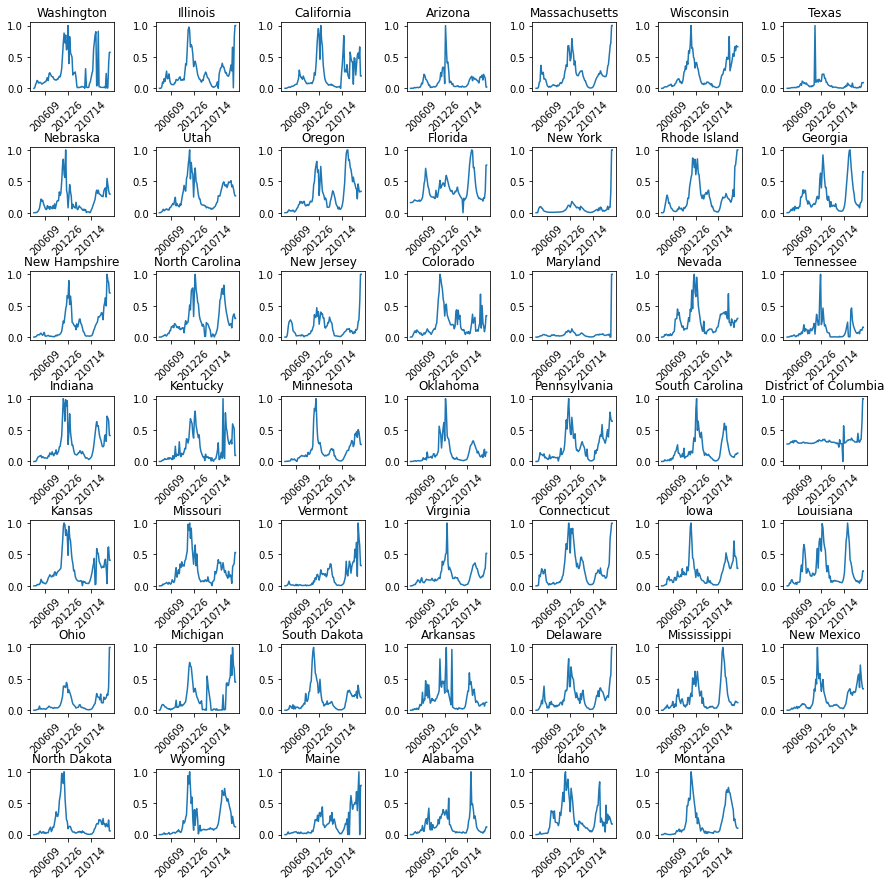

In [24]:
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
for i, state in enumerate(states):
    scaler = MinMaxScaler()
    p1, = axs[i//7][i%7].plot(scaler.fit_transform(get_state_data(state, epidemic, cols=['new_confirmed']).values))
    xticks = np.arange(100, len(selected_dates), 200)
    axs[i//7][i%7].set_title(state)
    axs[i//7][i%7].set_xticks(xticks)
    axs[i//7][i%7].set_xticklabels([selected_dates[i][2:].replace('-', '') for i in xticks],
                                 rotation=45)
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()
plt.close(fig)

##### 자기 상관(Auto Correlation Function, ACF)

1) 한 달 내에서 확인했을 때 약 7일의 주기가 있음 > 요일 별 검사량 때문일 가능성이 있음
2) 전체 기간으로 확인했을 때 계절성이 거의 없음

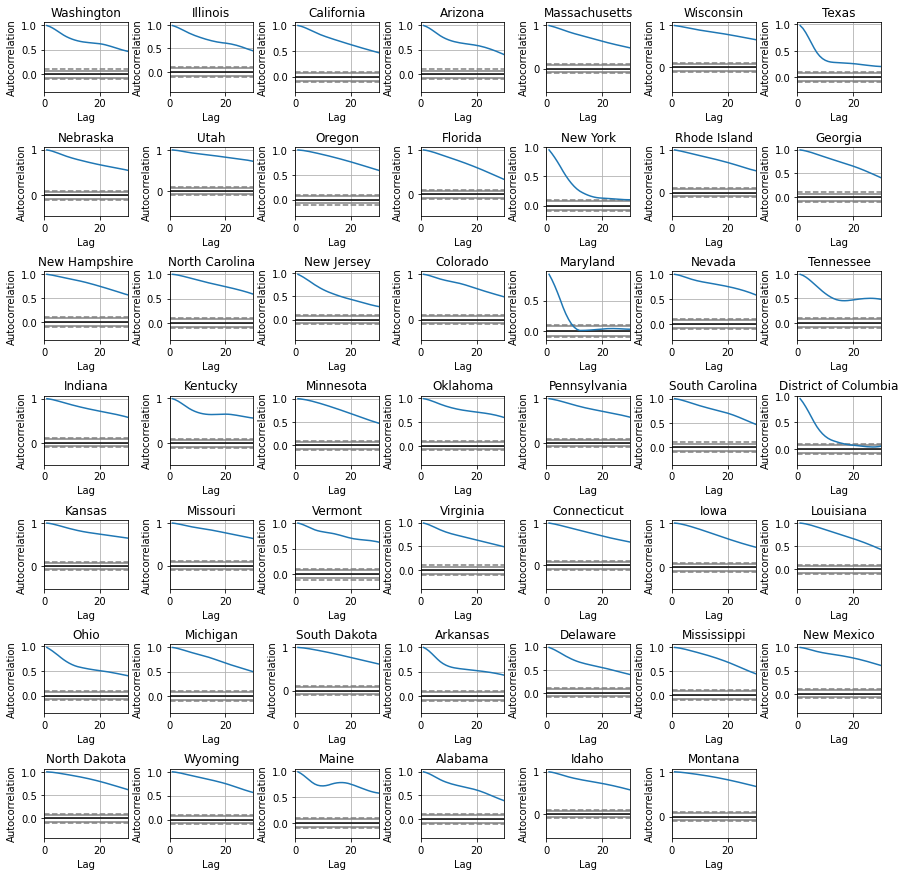

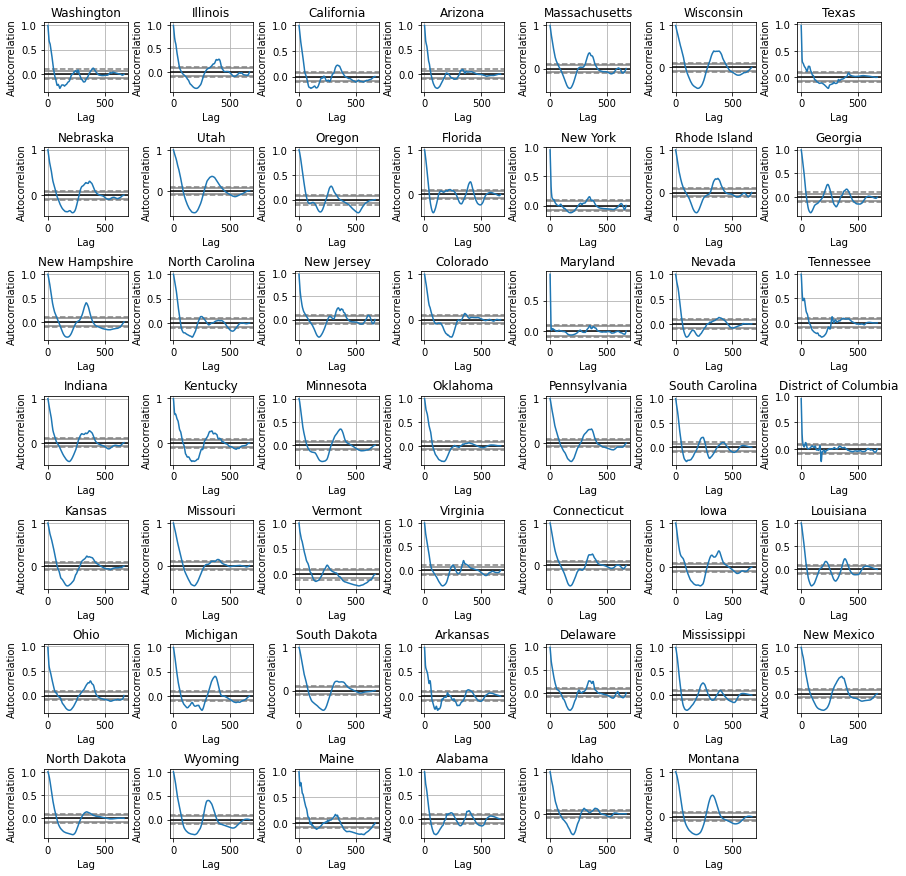

In [25]:
# 30일 
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
for i, state in enumerate(states):
    pd.plotting.autocorrelation_plot(get_state_data(state, epidemic),
                                   ax=axs[i//7][i%7])
    axs[i//7][i%7].set_title(state)
    axs[i//7][i%7].set_xlim([0, 30])
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()

#전체 기간
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
for i, state in enumerate(states):
    pd.plotting.autocorrelation_plot(get_state_data(state, epidemic),
                                   ax=axs[i//7][i%7])
    axs[i//7][i%7].set_title(state)
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()
plt.close(fig)

##### 교차 상관 (Cross correlation, XCorr)

해당 지역, 그리고 28일 차이의 교차 상관이 가장 높은 지역의 확진자 수를 확인(28일 shift)

피크는 많은 지역들이 비슷해서 괜찮았으나 작은 피크 혹은 급격한 상승과는 맞지 않았음

In [26]:
regions = pd.DataFrame({state: get_state_data(state, epidemic) for state in states})
temp_df = {'state' : [], 'max_state' : [], 'max_lag' : [], 'max_corr' : []}

for i, state in tqdm(enumerate(states)):
    max_corr = -1
    for region in regions:
        if state == region:
            continue
  
        for lag in range(1, 29):
            corr = regions[state].corr(regions[region].shift(lag))
    
            if corr > max_corr:
                max_corr = corr
                max_state = region
                max_lag = lag
    
    temp_df['state'].append(state)
    temp_df['max_state'].append(max_state)
    temp_df['max_lag'].append(max_lag)
    temp_df['max_corr'].append(max_corr)

temp_df = pd.DataFrame(temp_df)
    

48it [00:16,  2.94it/s]


In [27]:
temp_df = temp_df.sort_values(by = 'max_lag', ascending = False)
temp_df = temp_df.reset_index(drop = True)
temp_df[:10]

state     max_state  max_lag  max_corr
0      Kentucky          Utah       22  0.844213
1         Maine       Vermont       21  0.856565
2  Pennsylvania    New Mexico       19  0.916701
3      Colorado  South Dakota       14  0.867359
4      Illinois  South Dakota       13  0.862476
5      Virginia      Oklahoma       12  0.873491
6     Minnesota          Iowa        9  0.913861
7    Washington      Missouri        9  0.800849
8       Georgia   Mississippi        7  0.918972
9    California        Nevada        7  0.814706

48it [00:16,  2.89it/s]


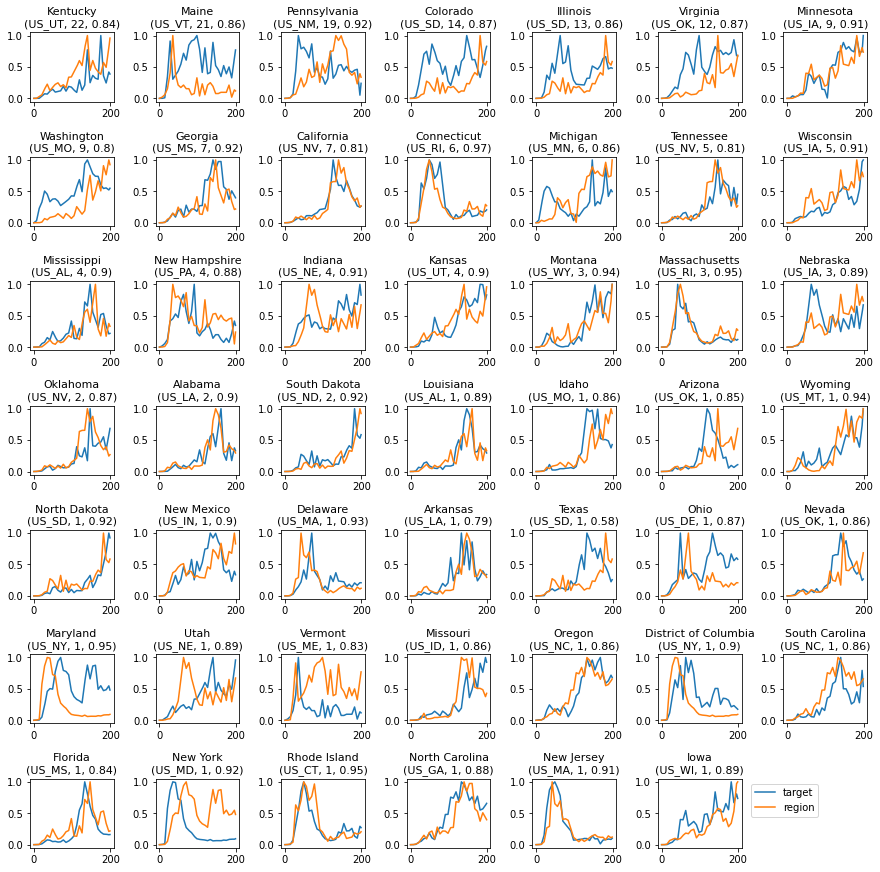

In [28]:
fig, axs = plt.subplots(7, 7, figsize=(15, 15))

regions = pd.DataFrame({state: get_state_data(state, epidemic) for state in states})

for i, state in tqdm(enumerate(temp_df['state'])):
    max_corr = -1
    for region in regions:
        if state == region:
            continue
  
        for lag in range(1, 29):
            corr = regions[state].corr(regions[region].shift(lag))
    
            if corr > max_corr:
                max_corr = corr
                max_state = region
                max_lag = lag
  
    scaler = MinMaxScaler()
    p1_norm = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed'])[:200])
    p2_norm = scaler.fit_transform(get_state_data(max_state, epidemic, ['new_confirmed'])[:200])
    
    p1, = axs[i//7][i%7].plot(p1_norm)
    p2, = axs[i//7][i%7].plot(p2_norm)
    
    axs[i//7][i%7].set_title('%s\n(%s, %s, %s)' % (
        state, 
        get_region_code(max_state), 
        max_lag, 
        round(max_corr, 2)), 
        fontsize=11
    )
    
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.legend([p1, p2], ['target', 'region'],
           bbox_to_anchor=(1.05, 1))
plt.show()
plt.close(fig)

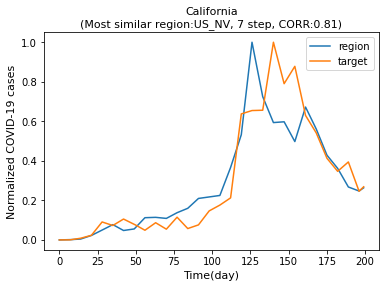

In [29]:
regions = pd.DataFrame({state: get_state_data(state, epidemic) for state in states})
max_corr = -1

state = 'California'

for region in regions:
    if state == region:
        continue
  
    for lag in range(1, 29):
        corr = regions[state].corr(regions[region].shift(lag))
    
        if corr > max_corr:
            max_corr = corr
            max_state = region
            max_lag = lag
  
scaler = MinMaxScaler()
p1_norm = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed'])[:200])
p2_norm = scaler.fit_transform(get_state_data(max_state, epidemic, ['new_confirmed'])[:200])
    
plt.plot(p1_norm, label='region')
plt.plot(p2_norm, label='target')
plt.title('%s\n(Most similar region:%s, %s step, CORR:%s)' % (state, 
    get_region_code(max_state), 
    max_lag, 
    round(max_corr, 2)), 
    fontsize=11
)
plt.xlabel('Time(day)', fontsize=11)
plt.ylabel('Normalized COVID-19 cases', fontsize=11)
plt.legend()
plt.show()

48it [00:16,  2.85it/s]


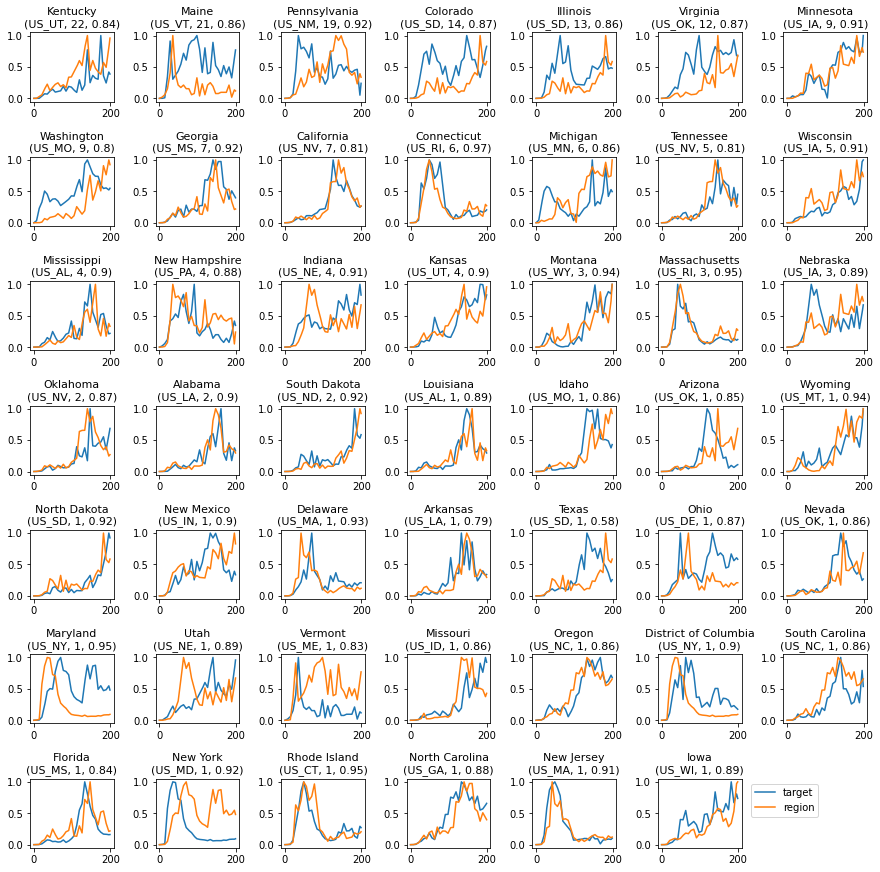

In [30]:
fig, axs = plt.subplots(7, 7, figsize=(15, 15))

regions = pd.DataFrame({state: get_state_data(state, epidemic) for state in states})

for i, state in tqdm(enumerate(temp_df['state'])):
    max_corr = -1
    for region in regions:
        if state == region:
            continue
  
        for lag in range(1, 29):
            corr = regions[state].corr(regions[region].shift(lag))
    
            if corr > max_corr:
                max_corr = corr
                max_state = region
                max_lag = lag
  
    scaler = MinMaxScaler()
    p1_norm = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed'])[:200])
    p2_norm = scaler.fit_transform(get_state_data(max_state, epidemic, ['new_confirmed'])[:200])
    
    p1, = axs[i//7][i%7].plot(p1_norm)
    p2, = axs[i//7][i%7].plot(p2_norm)
    
    axs[i//7][i%7].set_title('%s\n(%s, %s, %s)' % (
        state, 
        get_region_code(max_state), 
        max_lag, 
        round(max_corr, 2)), 
        fontsize=11
    )
    
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.legend([p1, p2], ['target', 'region'],
           bbox_to_anchor=(1.05, 1))
plt.show()
plt.close(fig)

## Top 10 주에 대한 shift 그리기

10it [00:03,  2.74it/s]


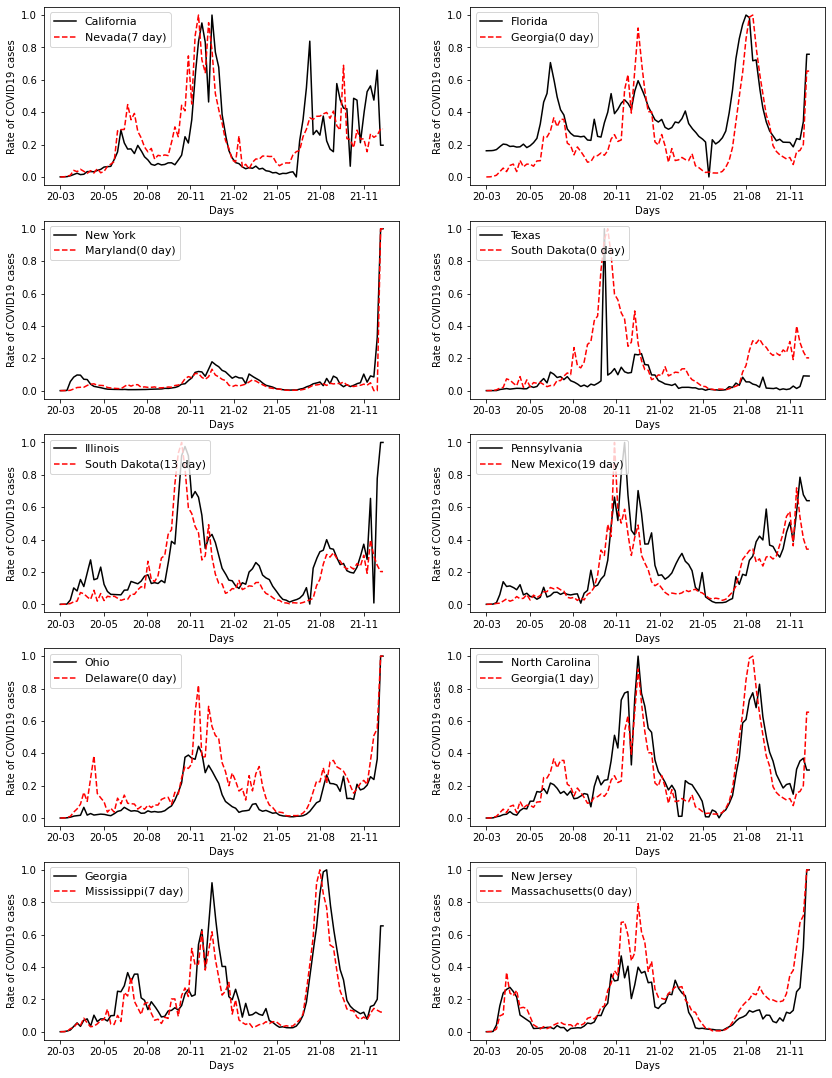

In [237]:
regions = pd.DataFrame({state: get_state_data(state, epidemic) for state in states})
fig, axs = plt.subplots(5, 2, figsize=(14, 19))
plt.rcParams['legend.fontsize'] = 11

for i, state in tqdm(enumerate(top10Cases['state'])):
    max_corr = -1
    for region in regions:
        if state == region:
            continue
  
        for lag in range(0, 29):
            corr = regions[state].corr(regions[region].shift(lag))
    
            if corr > max_corr:
                max_corr = corr
                max_state = region
                max_lag = lag
  
    scaler = MinMaxScaler()
    target_plot = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed']).values)
    region_plot = scaler.fit_transform(get_state_data(max_state, epidemic, ['new_confirmed']).values)
    shifted_plot = [np.arange(max_lag, len(selected_dates)), scaler.fit_transform(get_state_data(max_state, epidemic, ['new_confirmed']).values[:len(selected_dates)-max_lag])]
    
    date = epidemic[epidemic['key'] == get_region_code(state)]['date']
    date = date.reset_index(drop=True)
    xticks = [
        np.arange(0, len(date), 90),
        [datetime.strptime(date[idx], "%Y-%m-%d").strftime("%y-%m") for idx in np.arange(0, len(date), 90)]
    ]
    
    axs[i//2][i%2].plot(target_plot, color="black", label=state)
    axs[i//2][i%2].plot(region_plot, color="red", label=max_state + "(%s day)" % max_lag, linestyle="--")
    
    #axs[i//2][i%2].plot(shifted_plot[0], shifted_plot[1], color="blue", linestyle=":", label='%s (%s-day-shifted)' % (max_state, max_lag))
    axs[i//2][i%2].set_xticks(xticks[0], xticks[1])
    axs[i//2][i%2].legend(loc='upper left')
    axs[i//2][i%2].set_xlabel("Days")
    axs[i//2][i%2].set_ylabel("Rate of COVID19 cases")
plt.show()
plt.close(fig)

#### Google Trends

##### 교차 상관 분석

1) 전체 지역에서 다음과 같은 쿼리들이 등장
    - ageusia: 미맹, 미각 소실 (36개 지역)
    - hypoxemia: 저산소 혈증 (4개 지역)
    - palpitations: 심계항진, 두근거림 (2개 지역)
    - bruxism: 이갈이 (1개 지역)
    - dandruff: 비듬 (1개 지역)
    - paresthesia: 감각이상, 손발저림 (1개 지역)
    - tinnitus: 이명 (1개 지역)
    - periorbital puffiness: 안와부종 (1개 지역)
    - hypogonadism: 성선 기능 저하증 (1개 지역)
    
2) ageusia가 빈번히 등장함
3) ageusia, hypoxemia 외에는 눈으로 확인했을 때 크게 비슷해보이지 않음 (Missouri는 이상 값이 매우 비슷)

In [70]:
def skip_str(string, length):
    if len(string) > length:
        return string[:length] + "..."
    else:
        return string
    #end if
#end def

In [71]:
temp_df = {'state' : [], 'keyword' : [], 'max_lag' : [], 'max_corr' : []}

for i, state in tqdm(enumerate(list(states))):
    max_corr = -1
    tmp_state = get_state_data(state, epidemic)
    tmp_trends = get_state_data(state, trends, trends.columns[2:])
    for query in trends.columns[2:]:
        for lag in range(1, 29):
            corr = tmp_state.corr(tmp_trends[query].shift(lag))
            if corr > max_corr:
                max_corr = corr
                max_query_name = query
                max_lag = lag
                
    temp_df['state'].append(state)
    temp_df['keyword'].append(max_query_name)
    temp_df['max_lag'].append(max_lag)
    temp_df['max_corr'].append(max_corr)
    
temp_df = pd.DataFrame(temp_df)

48it [02:22,  2.97s/it]


In [75]:
temp_df = temp_df.sort_values(by='max_lag', ascending=False)
temp_df = temp_df.reset_index(drop=True)
temp_df[:10]

state                      keyword  max_lag  max_corr
0  District of Columbia       search_trends_hematoma       28  0.698020
1              New York       search_trends_hematoma       28  0.636789
2              Maryland       search_trends_hematoma       28  0.737231
3              Delaware     search_trends_tenderness       27  0.534408
4          North Dakota           search_trends_yawn       24  0.663069
5                 Texas  search_trends_bone_fracture       21  0.817121
6          South Dakota     search_trends_leukorrhea       17  0.740709
7             Tennessee        search_trends_ageusia       12  0.761870
8              Michigan        search_trends_ageusia       12  0.730892
9               Montana      search_trends_hypoxemia       10  0.641466

48it [00:01, 34.18it/s]


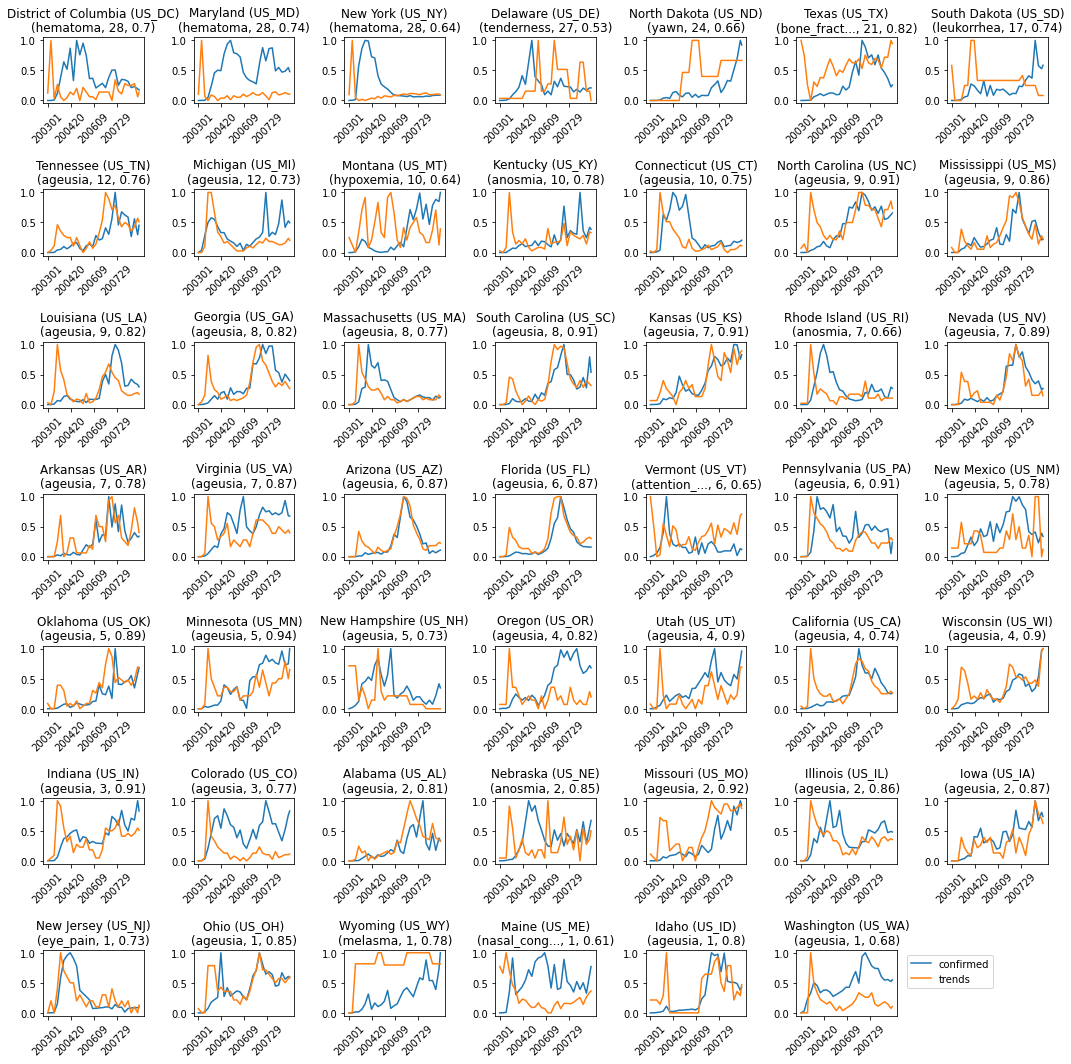

In [73]:
fig, axs = plt.subplots(7, 7, figsize=(18, 18))
for i, state in tqdm(enumerate(list(temp_df['state']))):
    max_corr = -1
    tmp_state = get_state_data(state, epidemic)
    tmp_trends = get_state_data(state, trends, trends.columns[2:])
    
    max_lag = temp_df[temp_df['state'] == state]['max_lag'].iloc[0]
    max_corr = temp_df[temp_df['state'] == state]['max_corr'].iloc[0]
    max_query_name = temp_df[temp_df['state'] == state]['keyword'].iloc[0]

    scaler = MinMaxScaler()
    
    p1_norm = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed'])[:200])
    p2_norm = scaler.fit_transform(get_state_data(state, trends, [max_query_name])[:200])
    
    p1, = axs[i//7][i%7].plot(p1_norm)
    p2, = axs[i//7][i%7].plot(p2_norm)
    
    xticks = np.arange(0, 200, 200 // 4)
    
    axs[i//7][i%7].set_title('%s (%s)\n(%s, %s, %s)' %  (state, get_region_code(state), skip_str(max_query_name.replace('search_trends_', ''), 10), max_lag, round(max_corr, 2)))
    axs[i//7][i%7].set_xticks(xticks)
    axs[i//7][i%7].set_xticklabels([selected_dates[i][2:].replace('-', '') for i in xticks],
                                 rotation=45)

    
fig.delaxes(axs[6][6])
plt.subplots_adjust(hspace=1.3, wspace=0.5)
plt.legend([p1, p2], ['confirmed', 'trends'], bbox_to_anchor=(1.05, 1))
plt.show()
plt.close(fig)

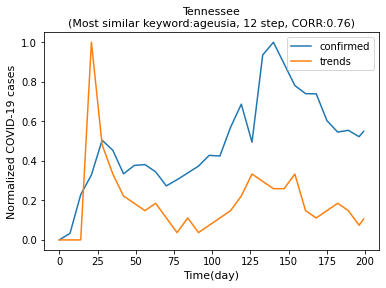

In [76]:

state = "Tennessee"


max_corr = -1
tmp_state = get_state_data(state, epidemic)
tmp_trends = get_state_data(state, trends, trends.columns[2:])
    
max_lag = temp_df[temp_df['state'] == state]['max_lag'].iloc[0]
max_corr = temp_df[temp_df['state'] == state]['max_corr'].iloc[0]
max_query_name = temp_df[temp_df['state'] == state]['keyword'].iloc[0]

scaler = MinMaxScaler()

plt.plot(p1_norm, label='confirmed')    
plt.plot(p2_norm, label='trends')
plt.title('%s\n(Most similar keyword:%s, %s step, CORR:%s)' % (state, 
    max_query_name.replace('search_trends_', ''), 
    max_lag, 
    round(max_corr, 2)), 
    fontsize=11
)
plt.xlabel('Time(day)', fontsize=11)
plt.ylabel('Normalized COVID-19 cases', fontsize=11)
plt.legend()
plt.show()

## Top 10 지역 트렌드 shift 그리기

10it [00:11,  1.10s/it]


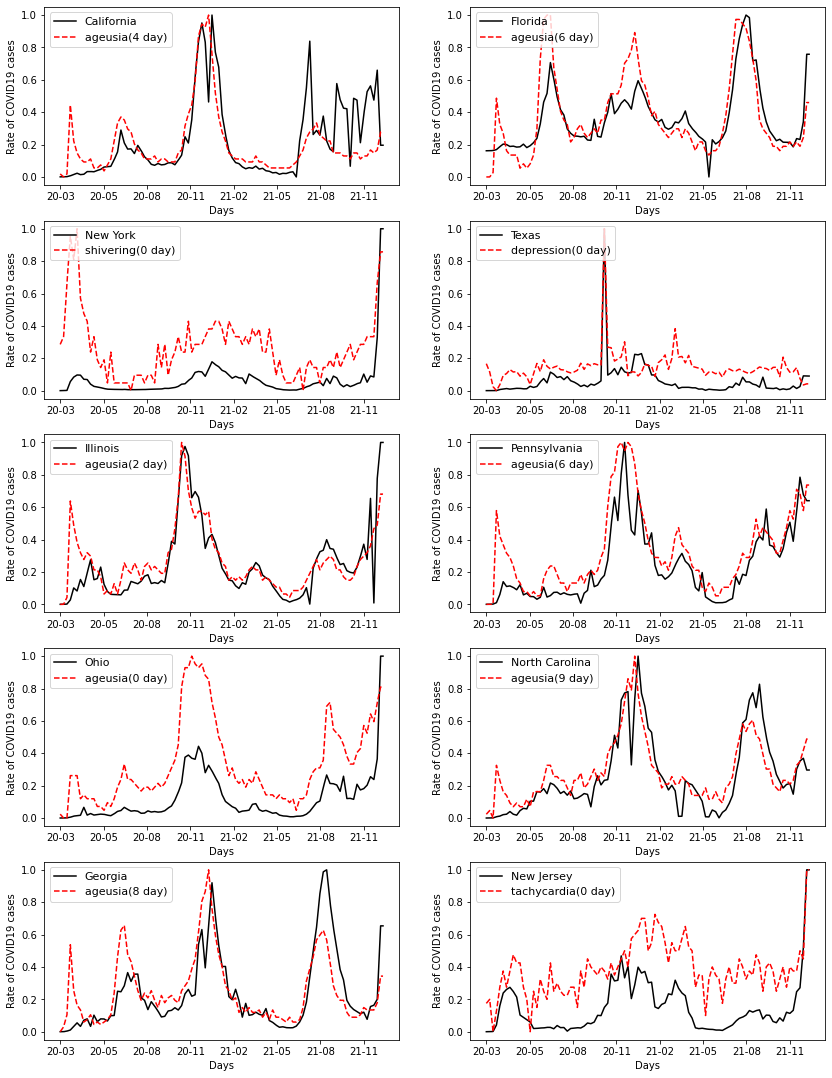

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

In [239]:
fig, axs = plt.subplots(5, 2, figsize=(14, 19))
plt.rcParams['legend.fontsize'] = 11

for i, state in tqdm(enumerate(list(top10Cases['state']))):
    max_corr = -1
    tmp_state = get_state_data(state, epidemic)
    tmp_trends = get_state_data(state, trends, trends.columns[2:])
    for query in trends.columns[2:]:
        for lag in range(0, 10):
            corr = tmp_state.corr(tmp_trends[query].shift(lag))
            if corr > max_corr:
                max_corr = corr
                max_query_name = query
                max_lag = lag
  
    scaler = MinMaxScaler()
    plt.figure(figsize=(8, 5))
    state_plot = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed']).values)
    query_plot = scaler.fit_transform(get_state_data(state, trends, [max_query_name]).values)
    shfited_plot = [range(max_lag, len(selected_dates)),scaler.fit_transform(get_state_data(state, trends, [max_query_name]).values)[:len(selected_dates)-max_lag]]
    
    date = trends[trends['key'] == get_region_code(state)]['date']
    date = date.reset_index(drop=True)
    xticks = [
        np.arange(0, len(date), 90),
        [datetime.strptime(date[idx], "%Y-%m-%d").strftime("%y-%m") for idx in np.arange(0, len(date), 90)]
    ]
    
    axs[i//2][i%2].plot(state_plot, color="black", label=state)
    axs[i//2][i%2].plot(query_plot, color="red", label=max_query_name.replace('search_trends_', '') + "(%s day)" % max_lag, linestyle="--")
    
    #axs[i//2][i%2].plot(shfited_plot[0], shfited_plot[1], color="blue", linestyle=":", label='%s (%s-day-shifted)' % (max_query_name.replace('search_trends_', ''), max_lag))
    axs[i//2][i%2].set_xticks(xticks[0], xticks[1])
    axs[i//2][i%2].legend(loc='upper left')
    axs[i//2][i%2].set_xlabel("Days")
    axs[i//2][i%2].set_ylabel("Rate of COVID19 cases")

plt.subplots_adjust(hspace=0.9, wspace=0.5)
plt.show()

## 데이터 전처리

### 데이터 정규화

0-1 사이 값으로 변환하는 MinMax Scaling 사용

In [31]:
scalers = {}
scaled_epidemic = pd.DataFrame(columns=list(epidemic.columns[:2])
                               + ['new_confirmed'])

for state in states:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(get_state_data(state, epidemic, ['new_confirmed']).values)
    tmp = pd.DataFrame(scaled, columns=['new_confirmed'])
    tmp['date'] = get_state_data(state, epidemic, 'date')
    tmp['key'] = get_region_code(state)
    scaled_epidemic = pd.concat([scaled_epidemic, tmp])
    scalers[state] = scaler

scaled_epidemic = scaled_epidemic.reset_index(drop=True)
scaled_epidemic

date    key  new_confirmed
0      2020-03-01  US_WA       0.000000
1      2020-03-02  US_WA       0.001185
2      2020-03-03  US_WA       0.002369
3      2020-03-04  US_WA       0.003554
4      2020-03-05  US_WA       0.004738
...           ...    ...            ...
32203  2021-12-27  US_MT       0.102314
32204  2021-12-28  US_MT       0.102314
32205  2021-12-29  US_MT       0.102314
32206  2021-12-30  US_MT       0.102314
32207  2021-12-31  US_MT       0.102314

[32208 rows x 3 columns]

In [32]:
scaled_trends = pd.DataFrame(columns=['key', 'date'] + [c.replace('search_trends_', '')
                                                for c in trends.columns[2:]])
for state in states:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(get_state_data(state, trends, trends.columns[2:]).values)
    tmp = pd.DataFrame(scaled, columns=[c.replace('search_trends_', '')
                                                for c in trends.columns[2:]])
    tmp['date'] = get_state_data(state, trends, 'date')
    tmp['key'] = get_region_code(state)
    scaled_trends = pd.concat([scaled_trends, tmp])
scaled_trends = scaled_trends.reset_index(drop=True)
scaled_trends

key        date  abdominal_obesity  abdominal_pain      acne  \
0      US_WA  2020-03-01           0.491713        0.686441  0.556818   
1      US_WA  2020-03-02           0.481452        0.663438  0.541048   
2      US_WA  2020-03-03           0.471192        0.640436  0.525278   
3      US_WA  2020-03-04           0.460931        0.617433  0.509508   
4      US_WA  2020-03-05           0.450671        0.594431  0.493738   
...      ...         ...                ...             ...       ...   
32203  US_MT  2021-12-27           0.077348        0.595628  0.455172   
32204  US_MT  2021-12-28           0.077348        0.595628  0.455172   
32205  US_MT  2021-12-29           0.077348        0.595628  0.455172   
32206  US_MT  2021-12-30           0.077348        0.595628  0.455172   
32207  US_MT  2021-12-31           0.077348        0.595628  0.455172   

       actinic_keratosis  acute_bronchitis  adrenal_crisis  ageusia  \
0               0.235294          0.892473        0.080000      0.0   
1               0.218487          0.886329        0.082857      0.0   
2               0.201681          0.880184        0.085714      0.0   
3               0.184874          0.874040        0.088571      0.0   
4               0.168067          0.867896        0.091429      0.0   
...                  ...               ...             ...      ...   
32203           0.173913          0.730769        0.000000      0.0   
32204           0.173913          0.730769        0.000000      0.0   
32205           0.173913          0.730769        0.000000      0.0   
32206           0.173913          0.730769        0.000000      0.0   
32207           0.173913          0.730769        0.000000      0.0   

       alcoholism  ...  visual_acuity  vomiting      wart  water_retention  \
0        0.145482  ...       0.538462  1.000000  0.492754         0.195122   
1        0.135638  ...       0.538462  0.967857  0.469979         0.188153   
2        0.125793  ...       0.538462  0.935714  0.447205         0.181185   
3        0.115948  ...       0.538462  0.903571  0.424431         0.174216   
4        0.106104  ...       0.538462  0.871429  0.401656         0.167247   
...           ...  ...            ...       ...       ...              ...   
32203    0.131213  ...       0.133333  0.692308  0.137500         0.081081   
32204    0.131213  ...       0.133333  0.692308  0.137500         0.081081   
32205    0.131213  ...       0.133333  0.692308  0.137500         0.081081   
32206    0.131213  ...       0.133333  0.692308  0.137500         0.081081   
32207    0.131213  ...       0.133333  0.692308  0.137500         0.081081   

       weakness  weight_gain    wheeze  xeroderma  xerostomia      yawn  
0      0.687500     0.587097  0.552632   0.308290    0.631579  0.300000  
1      0.705357     0.570507  0.556391   0.301628    0.631579  0.328571  
2      0.723214     0.553917  0.560150   0.294967    0.631579  0.357143  
3      0.741071     0.537327  0.563910   0.288305    0.631579  0.385714  
4      0.758929     0.520737  0.567669   0.281643    0.631579  0.414286  
...         ...          ...       ...        ...         ...       ...  
32203  0.172414     0.251282  0.100000   0.348684    0.733333  0.000000  
32204  0.172414     0.251282  0.100000   0.348684    0.733333  0.000000  
32205  0.172414     0.251282  0.100000   0.348684    0.733333  0.000000  
32206  0.172414     0.251282  0.100000   0.348684    0.733333  0.000000  
32207  0.172414     0.251282  0.100000   0.348684    0.733333  0.000000  

[32208 rows x 424 columns]

### 교차 상관 계수 계산

1) 타겟 지역의 누적 확진자를 base
2) 다른 지역의 확진자 or 해당 지역의 쿼리를 0\~28(maxlag)칸씩 오른쪽으로 shift하며 base와 상관관계  계산
3) 각 lag별 가장 높은 상관 관계(max_corr)와 해당 데이터의 이름(max_name)을 기록
4) 타겟 지역을 변경해가며 1~5)의 과정을 반복하고 테이블을 병합

In [33]:
MAXLAG = 28
update_force = False

In [34]:
xcorr_epidemic_fname = data_path + 'us_xcorr_epidemic.csv'

if os.path.exists(xcorr_epidemic_fname) and not update_force == True:
    xcorr_epidemic = pd.read_csv(xcorr_epidemic_fname)
else:
    xcorr_epidemic = pd.DataFrame()

    for state in tqdm(states, position=0):
        base = get_state_data(state, scaled_epidemic)
        regions = pd.DataFrame({state: get_state_data(state, scaled_epidemic) 
                                    for state in states})
    
        sub_epidemic = []
        for _, target_cases in regions.items():
            sub_epidemic.append(
                [base.corr(target_cases.shift(i)) for i in range(MAXLAG+1)])

        sub_epidemic = pd.DataFrame(np.array(sub_epidemic).T,
                                  columns=regions.columns)
        sub_epidemic['max_name'] = sub_epidemic[
          [sub_state for sub_state in sub_epidemic if state != sub_state]
        ].idxmax(axis=1)
        sub_epidemic['max_corr'] = sub_epidemic[
          [sub_state for sub_state in sub_epidemic if state != sub_state]
        ].max(axis=1)

        xcorr_epidemic = pd.concat([
          xcorr_epidemic,
          pd.concat([
            pd.DataFrame({'key': get_region_code(state),
                        'lag': np.arange(MAXLAG+1)}),
            sub_epidemic], axis=1)
        ])

    xcorr_epidemic = xcorr_epidemic.reset_index(drop=True)
    xcorr_epidemic.to_csv(xcorr_epidemic_fname, index=False)
xcorr_epidemic

key  lag  Washington  Illinois  California   Arizona  Massachusetts  \
0     US_WA    0    1.000000  0.640142    0.548547  0.548336       0.517647   
1     US_WA    1    0.993131  0.645826    0.546687  0.548219       0.515937   
2     US_WA    2    0.975097  0.650421    0.544593  0.551544       0.513288   
3     US_WA    3    0.948459  0.654043    0.542392  0.556990       0.509798   
4     US_WA    4    0.915803  0.656809    0.540209  0.563232       0.505572   
...     ...  ...         ...       ...         ...       ...            ...   
1387  US_MT   24    0.367060  0.535234    0.213406  0.132617       0.097665   
1388  US_MT   25    0.363019  0.522774    0.208193  0.124226       0.087108   
1389  US_MT   26    0.358738  0.511085    0.203412  0.116039       0.076509   
1390  US_MT   27    0.354307  0.500250    0.199061  0.107972       0.065858   
1391  US_MT   28    0.349851  0.488551    0.195047  0.099834       0.055153   

      Wisconsin     Texas  Nebraska  ...  Mississippi  New Mexico  \
0      0.442406  0.421291  0.534291  ...     0.745176    0.555321   
1      0.446634  0.426534  0.538606  ...     0.739030    0.556455   
2      0.450701  0.432846  0.542271  ...     0.731788    0.557472   
3      0.454667  0.439898  0.545389  ...     0.723316    0.558487   
4      0.458593  0.447365  0.548061  ...     0.713477    0.559614   
...         ...       ...       ...  ...          ...         ...   
1387   0.712957  0.323516  0.598627  ...     0.492192    0.480247   
1388   0.702383  0.311417  0.588179  ...     0.494590    0.468580   
1389   0.691694  0.299353  0.577883  ...     0.496899    0.457065   
1390   0.681030  0.287383  0.567592  ...     0.499107    0.445769   
1391   0.670101  0.275588  0.556409  ...     0.501200    0.433604   

      North Dakota   Wyoming     Maine   Alabama     Idaho   Montana  \
0         0.387554  0.473245  0.081890  0.769372  0.665541  0.424970   
1         0.398963  0.470997  0.076088  0.763412  0.674759  0.424036   
2         0.410311  0.470382  0.073175  0.755888  0.686595  0.423105   
3         0.421572  0.470981  0.072278  0.747143  0.699865  0.422136   
4         0.432720  0.472374  0.072495  0.737523  0.713382  0.421087   
...            ...       ...       ...       ...       ...       ...   
1387      0.717552  0.766459  0.188519  0.429146  0.626591  0.777607   
1388      0.708804  0.752084  0.179641  0.430681  0.620271  0.763119   
1389      0.699672  0.737539  0.170108  0.432220  0.613663  0.748388   
1390      0.690160  0.722848  0.159889  0.433875  0.606578  0.733446   
1391      0.680282  0.707907  0.149001  0.435753  0.598781  0.718266   

       max_name  max_corr  
0     Louisiana  0.795982  
1     Louisiana  0.792528  
2     Louisiana  0.787838  
3     Louisiana  0.781870  
4      Missouri  0.779518  
...         ...       ...  
1387    Wyoming  0.766459  
1388    Wyoming  0.752084  
1389    Wyoming  0.737539  
1390    Wyoming  0.722848  
1391    Wyoming  0.707907  

[1392 rows x 52 columns]

In [35]:
xcorr_reg = pd.DataFrame(columns=np.arange(0, MAXLAG+1))

for state in states:
    regCode = get_region_code(state)
    xcorr_state = xcorr_epidemic[xcorr_epidemic['key'] == regCode]
    temp = []
    for step in xcorr_state['lag']:
        xcorr_step = xcorr_state[xcorr_state['lag'] == step][xcorr_state.columns[2:]]
        max_name = get_region_code(xcorr_step['max_name'].to_list()[0])[3:]
        max_corr = xcorr_step['max_corr'].to_list()[0]
        
        temp.append(max_name + ", " + str(round(max_corr, 2)))
    #end for
    xcorr_reg = pd.concat([xcorr_reg, pd.DataFrame(temp).T])
#end for

xcorr_reg.index = [get_region_code(state)[3:] for state in states]
xcorr_reg.to_excel('./xcorr_reg.xlsx')

xcorr_reg

0         1         2         3         4         5         6   \
WA   LA, 0.8  LA, 0.79  LA, 0.79  LA, 0.78  MO, 0.78  MO, 0.79  MO, 0.79   
IL  OH, 0.85  OH, 0.85  NE, 0.85  NE, 0.84  NE, 0.84  NE, 0.84  SD, 0.84   
CA  NV, 0.78  NV, 0.79  NV, 0.79   NV, 0.8  NV, 0.81  NV, 0.81  NV, 0.81   
AZ  OK, 0.85  OK, 0.85  OK, 0.84  OK, 0.82   OK, 0.8  OK, 0.78  NV, 0.77   
MA  RI, 0.95  RI, 0.95  RI, 0.95  RI, 0.95  RI, 0.95  RI, 0.95  RI, 0.95   
WI  IA, 0.89   IA, 0.9   IA, 0.9   IA, 0.9  IA, 0.91  IA, 0.91  IA, 0.91   
TX  SD, 0.58  SD, 0.58  SD, 0.58  SD, 0.57  SD, 0.56  SD, 0.55  SD, 0.54   
NE  UT, 0.89  IA, 0.89  IA, 0.89  IA, 0.89  IA, 0.89  IA, 0.89  SD, 0.89   
UT  KS, 0.89  NE, 0.89  NE, 0.89  NE, 0.89  NE, 0.88  MT, 0.88  SD, 0.88   
OR  NC, 0.87  NC, 0.86  NC, 0.85  NC, 0.84  NC, 0.83  MS, 0.83  MS, 0.83   
FL  GA, 0.85  MS, 0.84  MS, 0.83  MS, 0.82  MS, 0.81  MS, 0.79  MS, 0.78   
NY  MD, 0.94  MD, 0.92  MD, 0.89  DC, 0.87  DC, 0.85  DC, 0.82  DC, 0.79   
RI  CT, 0.95  CT, 0.95  MA, 0.94  MA, 0.93  MA, 0.93  MA, 0.92  MA, 0.91   
GA  MS, 0.89   MS, 0.9  MS, 0.91  MS, 0.91  MS, 0.91  MS, 0.92  MS, 0.92   
NH  PA, 0.87  PA, 0.88  PA, 0.88  PA, 0.88  PA, 0.88  PA, 0.88  PA, 0.88   
NC  GA, 0.88  GA, 0.88  GA, 0.88  GA, 0.88  GA, 0.87  SC, 0.87  SC, 0.87   
NJ  MA, 0.91  MA, 0.91   MA, 0.9  MA, 0.89  MA, 0.89  MA, 0.87  MA, 0.86   
CO  MN, 0.83  MN, 0.83  IL, 0.82  IL, 0.83  IL, 0.83  IL, 0.84  IL, 0.84   
MD  NY, 0.94  NY, 0.95  NY, 0.95  NY, 0.94  NY, 0.92   NY, 0.9  NY, 0.87   
NV  OK, 0.86  OK, 0.86  OK, 0.85  OK, 0.84  KS, 0.83  KS, 0.83  KS, 0.82   
TN  NV, 0.78  NV, 0.79   NV, 0.8  NV, 0.81  NV, 0.81  NV, 0.81  NV, 0.81   
IN   NM, 0.9   NM, 0.9   NE, 0.9  NE, 0.91  NE, 0.91   NE, 0.9   NE, 0.9   
KY  KS, 0.81  KS, 0.81  KS, 0.81  KS, 0.81  KS, 0.81  KS, 0.81   UT, 0.8   
MN  NM, 0.89  NM, 0.89  NM, 0.88  NM, 0.88  IA, 0.89   IA, 0.9   IA, 0.9   
OK  NV, 0.86  NV, 0.87  NV, 0.87  NV, 0.87  NV, 0.86  NV, 0.86  NV, 0.85   
PA   RI, 0.9   RI, 0.9   RI, 0.9   RI, 0.9   RI, 0.9   RI, 0.9   RI, 0.9   
SC  NC, 0.86  NC, 0.86  NC, 0.85  NC, 0.85  GA, 0.85  GA, 0.85  GA, 0.85   
DC   NY, 0.9   NY, 0.9  NY, 0.88  NY, 0.86  NY, 0.84  NY, 0.81  NY, 0.78   
KS  UT, 0.89   UT, 0.9   UT, 0.9   UT, 0.9   UT, 0.9   UT, 0.9   UT, 0.9   
MO  ID, 0.86  ID, 0.86  ID, 0.86  ID, 0.85  ID, 0.85  ID, 0.84  SD, 0.85   
VT  ME, 0.83  ME, 0.83  ME, 0.83  ME, 0.83  ME, 0.82  ME, 0.82  ME, 0.82   
VA  NC, 0.85  NC, 0.86  NC, 0.86  NC, 0.86  NC, 0.87  NC, 0.87  NC, 0.87   
CT  RI, 0.95  RI, 0.96  RI, 0.96  RI, 0.97  RI, 0.97  RI, 0.97  RI, 0.97   
IA  WI, 0.89  WI, 0.89  WI, 0.88  WI, 0.88  SD, 0.87  SD, 0.88  SD, 0.88   
LA   AL, 0.9  AL, 0.89  AL, 0.88  AL, 0.87  AL, 0.85  AL, 0.84  AL, 0.82   
OH  DE, 0.88  DE, 0.87  DE, 0.86  IL, 0.85  IL, 0.85  IL, 0.84  IL, 0.83   
MI  MN, 0.84  MN, 0.85  MN, 0.86  MN, 0.86  MN, 0.86  MN, 0.86  MN, 0.86   
SD  ND, 0.92  ND, 0.92  ND, 0.92  ND, 0.92  ND, 0.92  ND, 0.92  ND, 0.92   
AR   LA, 0.8  LA, 0.79  LA, 0.78  LA, 0.77  LA, 0.76  LA, 0.74  LA, 0.72   
DE  MA, 0.93  MA, 0.93  MA, 0.93  MA, 0.93  MA, 0.92  MA, 0.91  RI, 0.91   
MS  GA, 0.89  AL, 0.89  AL, 0.89   AL, 0.9   AL, 0.9   AL, 0.9  AL, 0.89   
NM   IN, 0.9   IN, 0.9  UT, 0.89  UT, 0.89  UT, 0.89  UT, 0.89  UT, 0.89   
ND  SD, 0.92  SD, 0.92  SD, 0.92  SD, 0.91  SD, 0.91  SD, 0.91   SD, 0.9   
WY  MT, 0.94  MT, 0.94  MT, 0.93  MT, 0.93  MT, 0.92  MT, 0.91  MT, 0.91   
ME  NH, 0.83  VT, 0.83  VT, 0.84  VT, 0.84  VT, 0.83  VT, 0.83  VT, 0.83   
AL   LA, 0.9   LA, 0.9   LA, 0.9   LA, 0.9   LA, 0.9  LA, 0.89  LA, 0.88   
ID  MO, 0.86  MO, 0.86  MO, 0.86  MO, 0.85  MO, 0.85  MO, 0.84  MO, 0.84   
MT  WY, 0.94  WY, 0.94  WY, 0.94  WY, 0.94  WY, 0.94  WY, 0.94  WY, 0.94   

          7         8         9   ...        19        20        21        22  \
WA   MO, 0.8   MO, 0.8   MO, 0.8  ...  MO, 0.76  MO, 0.76  MO, 0.75  MO, 0.74   
IL  SD, 0.84  SD, 0.85  SD, 0.85  ...  SD, 0.82  SD, 0.81   SD, 0.8  SD, 0.79   
CA  NV, 0.81  NV, 0.81  NV, 0.81  ...  OH,

In [36]:
xcorr_trends_fname = data_path + 'us_xcorr_trends.csv'

if os.path.exists(xcorr_trends_fname) and not update_force == True:
    xcorr_trends = pd.read_csv(xcorr_trends_fname)
else:
    xcorr_trends = pd.DataFrame()

    for state in tqdm(states, position=0):
        base = get_state_data(state, scaled_epidemic)
        queries = get_state_data(state, scaled_trends, scaled_trends.columns[2:])

        sub_trends = []
        for _, target_trends in queries.items():
            sub_trends.append(
                [base.corr(target_trends.shift(i)) for i in range(MAXLAG+1)])

        sub_trends = pd.DataFrame(np.array(sub_trends).T,
                                    columns=queries.columns)
        sub_trends['max_name'] = sub_trends.idxmax(axis=1)
        sub_trends['max_corr'] = sub_trends.max(axis=1)


        xcorr_trends = pd.concat([
          xcorr_trends, 
          pd.concat([
            pd.DataFrame({'key': get_region_code(state),
                        'lag': np.arange(MAXLAG+1)}),
            sub_trends], axis=1)
          ])

    xcorr_trends = xcorr_trends.reset_index(drop=True)
    xcorr_trends.to_csv(xcorr_trends_fname, index=False)
xcorr_trends

key  lag  abdominal_obesity  abdominal_pain      acne  \
0     US_WA    0          -0.243077        0.209276 -0.008880   
1     US_WA    1          -0.249383        0.204992 -0.010742   
2     US_WA    2          -0.254733        0.201294 -0.012689   
3     US_WA    3          -0.259143        0.198224 -0.014681   
4     US_WA    4          -0.262630        0.195824 -0.016675   
...     ...  ...                ...             ...       ...   
1387  US_MT   24          -0.652879        0.006639 -0.416299   
1388  US_MT   25          -0.654586       -0.000973 -0.423838   
1389  US_MT   26          -0.656451       -0.008710 -0.431376   
1390  US_MT   27          -0.658486       -0.016472 -0.438915   
1391  US_MT   28          -0.660162       -0.023881 -0.446349   

      actinic_keratosis  acute_bronchitis  adrenal_crisis   ageusia  \
0             -0.211779         -0.138324       -0.004039  0.682359   
1             -0.208923         -0.135582       -0.008853  0.678271   
2             -0.205182         -0.132990       -0.014599  0.674076   
3             -0.200473         -0.130457       -0.020750  0.669602   
4             -0.194712         -0.127892       -0.026779  0.664678   
...                 ...               ...             ...       ...   
1387          -0.186037         -0.009159             NaN       NaN   
1388          -0.178643         -0.012427             NaN       NaN   
1389          -0.171669         -0.016067             NaN       NaN   
1390          -0.164849         -0.020103             NaN       NaN   
1391          -0.157612         -0.024316             NaN       NaN   

      alcoholism  ...      wart  water_retention  weakness  weight_gain  \
0      -0.070868  ... -0.142557        -0.290486  0.034904    -0.115926   
1      -0.072779  ... -0.142846        -0.293010  0.040824    -0.124565   
2      -0.074536  ... -0.143312        -0.294598  0.049112    -0.130469   
3      -0.075901  ... -0.143581        -0.295076  0.059217    -0.133978   
4      -0.076634  ... -0.143268        -0.294272  0.070569    -0.135436   
...          ...  ...       ...              ...       ...          ...   
1387    0.022683  ... -0.323825        -0.277325 -0.109233    -0.287486   
1388    0.016999  ... -0.319661        -0.272075 -0.109610    -0.288945   
1389    0.011287  ... -0.314475        -0.266876 -0.110027    -0.290815   
1390    0.005576  ... -0.308096        -0.261872 -0.110386    -0.293058   
1391   -0.000041  ... -0.300088        -0.257377 -0.110146    -0.295450   

        wheeze  xeroderma  xerostomia      yawn   max_name  max_corr  
0    -0.135807  -0.018959    0.273540 -0.199511    ageusia  0.682359  
1    -0.136286  -0.022109    0.252107 -0.197750    ageusia  0.678271  
2    -0.136654  -0.025768    0.231344 -0.193526  dysgeusia  0.675467  
3    -0.137243  -0.029619    0.211936 -0.187562  dysgeusia  0.676094  
4    -0.138382  -0.033346    0.194568 -0.180585  dysgeusia  0.675456  
...        ...        ...         ...       ...        ...       ...  
1387 -0.117260  -0.331406   -0.186611 -0.185607  hypoxemia  0.581717  
1388 -0.113144  -0.341483   -0.196573 -0.190509  hypoxemia  0.573780  
1389 -0.108219  -0.351798   -0.206291 -0.195096  hypoxemia  0.565827  
1390 -0.102511  -0.362217   -0.215880 -0.199304  hypoxemia  0.558029  
1391 -0.096181  -0.372240   -0.225192 -0.203161  hypoxemia  0.550418  

[1392 rows x 426 columns]

#### 각 주에서 최대 28 step 만큼 시간차를 볼 때 가장 CORR 가 높은 Step 과 유사도
#### 각 주들의 데이터가 어떤 Step 에서 CORR 가 가장 높게 나타나는가?

In [37]:
scatter_epidemic = []
for state in states:
    xcorr_region = xcorr_epidemic[xcorr_epidemic['key']==get_region_code(state)]
    corr_max_idx = xcorr_region['max_corr'].idxmax()
    scatter_epidemic.append(xcorr_region.loc[corr_max_idx, ['lag', 'max_corr']].to_list())

In [38]:
scatter_trends = []
for state in states:
    xcorr_region = xcorr_trends[xcorr_trends['key']==get_region_code(state)]
    corr_max_idx = xcorr_region['max_corr'].idxmax()
    scatter_trends.append(xcorr_region.loc[corr_max_idx, ['lag', 'max_corr']].to_list())

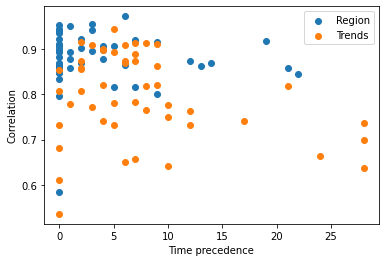

In [39]:
epi_x, epi_y = zip(*scatter_epidemic)
tre_x, tre_y = zip(*scatter_trends)
plt.scatter(epi_x, epi_y, label='Region')
plt.scatter(tre_x, tre_y, label='Trends')
plt.xlabel('Time precedence')
plt.ylabel('Correlation')
plt.legend()
plt.show()
plt.close()

In [40]:
heatmap_epidemic = []
for state in states:
    xcorr_region = xcorr_epidemic[xcorr_epidemic['key']==get_region_code(state)]
    corr_max_idx = xcorr_region['max_corr'].idxmax()
    corr_max_name = xcorr_region.loc[corr_max_idx, 'max_name']
    heatmap_epidemic.append(xcorr_region[corr_max_name].to_list()[:])
heatmap_epidemic.sort(key=lambda x: x.index(max(x)))

In [41]:
heatmap_trends = []
for state in states:
    xcorr_region = xcorr_trends[xcorr_trends['key']==get_region_code(state)]
    corr_max_idx = xcorr_region['max_corr'].idxmax()
    corr_max_name = xcorr_region.loc[corr_max_idx, 'max_name']
    heatmap_trends.append(xcorr_region[corr_max_name].to_list()[:])
heatmap_trends.sort(key=lambda x: x.index(max(x)))

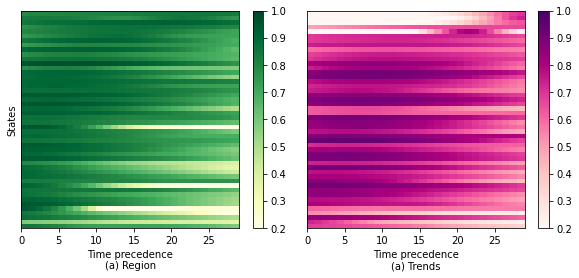

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pc0 = axes[0].pcolor(heatmap_epidemic, cmap='YlGn', vmin=0.2, vmax=1.0)
pc1 = axes[1].pcolor(heatmap_trends, cmap='RdPu', vmin=0.2, vmax=1.0)
axes[0].set_ylabel('States')
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[0].set_xlabel('Time precedence\n(a) Region')
axes[1].set_xlabel('Time precedence\n(a) Trends')
fig.colorbar(pc0, ax=axes[0])
fig.colorbar(pc1, ax=axes[1])
plt.subplots_adjust(wspace=0.05)
plt.show()
plt.close()

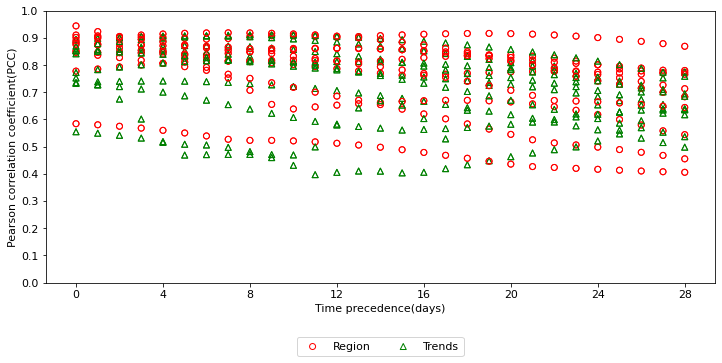

In [43]:
temp = {"leg" : [], "state" : [], "data_name" : [], "corr" : []}

plt.figure(figsize=(12, 5))
for state in top10Cases['state']:
    p1 = None
    p2 = None
    p3 = None
    
    scatter_epi = xcorr_epidemic[xcorr_epidemic['key']==get_region_code(state)]['max_corr'].tolist()
    scatter_tre = xcorr_trends[xcorr_trends['key']==get_region_code(state)]['max_corr'].tolist()
    
    scatters = {"Region" : scatter_epi, "Trend" : scatter_tre}
    for scatters_key in list(scatters.keys()):
        for i in range(len(scatters[scatters_key])):
            temp["leg"].append(i)
            temp["state"].append(state)
            temp["data_name"].append(scatters_key)
            temp["corr"].append(scatters[scatters_key][i])
    
        p1 = plt.scatter(np.arange(0, len(scatter_epi)), scatter_epi, facecolors='none', edgecolors='r')
        p2 = plt.scatter(np.arange(0, len(scatter_tre)), scatter_tre, marker='^', facecolors='none', edgecolors='g')
#end for
top10Table = pd.DataFrame.from_dict(temp)

plt.xlabel("Time precedence(days)", fontsize=11)
plt.ylabel("Pearson correlation coefficient(PCC)", fontsize=11)
plt.yticks(np.round(np.arange(0, 1.1, 0.1), 1), fontsize=11)
plt.xticks(np.arange(0, len(scatter_epi), int(len(scatter_epi) / 7)), fontsize=11)
plt.legend([p1, p2], ["Region", "Trends"], bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=3, fontsize=11)
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_4944\1066491243.py:42: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([p1, p2, p3], list(scatter_color.keys()), bbox_to_anchor=(-1.5, -0.4), loc="lower center", ncol=3)


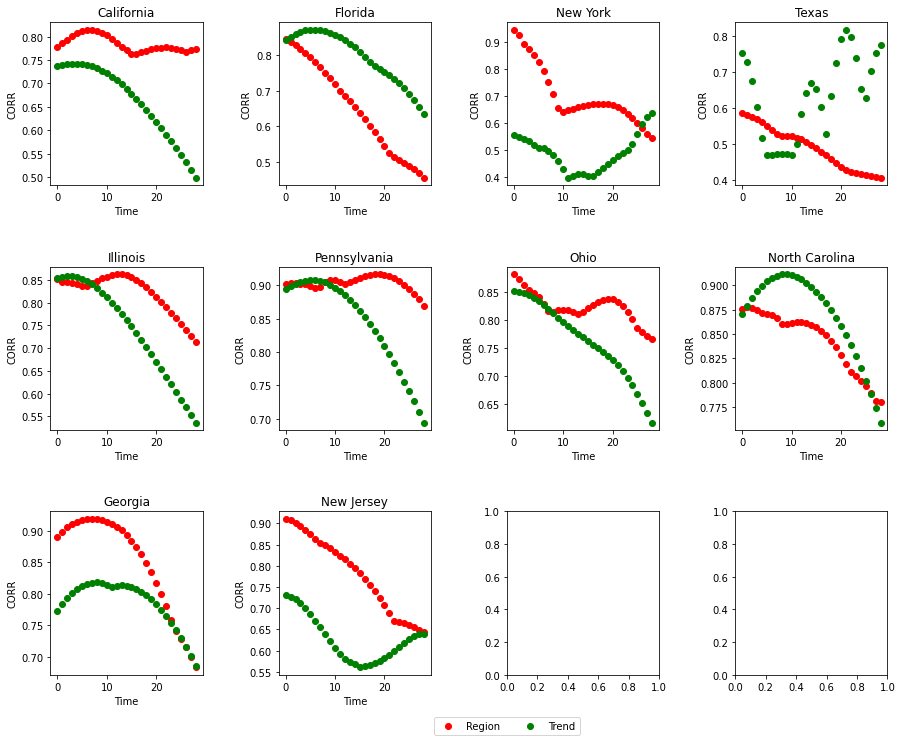

In [44]:
import math

scatter_color = {
    "Region" : "red",
    "Trend" : "green",
    "Word2VecTrend" : "blue"
}

states_temp = []
for i in range(len(top10Table)):
    if not top10Table.loc[i]['state'] in states_temp:
        states_temp.append(top10Table.loc[i]['state'])
        
col_size = int(math.sqrt(len(states_temp)))
row_size = int(len(states_temp) / col_size) + int(not len(states_temp) % col_size == 0)
fig, axes = plt.subplots(col_size, row_size, figsize=(15, 12))        

for k, state in enumerate(states_temp):
    df = top10Table[top10Table['state'] == state]
    region_count = 0
    trend_count = 0
    w2vtrend_count = 0
    
    for i in range(len(df)):
        if df.iloc[i]['data_name'] == "Region":
            p1 = axes[k//row_size][k%row_size].scatter(df.iloc[i]['leg'], df.iloc[i]['corr'], label=df.iloc[i]['data_name'], color=scatter_color[df.iloc[i]['data_name']])
            region_count += 1
        elif df.iloc[i]['data_name'] == "Trend":
            p2 = axes[k//row_size][k%row_size].scatter(df.iloc[i]['leg'], df.iloc[i]['corr'], label=df.iloc[i]['data_name'], color=scatter_color[df.iloc[i]['data_name']])
            trend_count += 1
        elif df.iloc[i]['data_name'] == "Word2VecTrend":
            p3 = axes[k//row_size][k%row_size].scatter(df.iloc[i]['leg'], df.iloc[i]['corr'], label=df.iloc[i]['data_name'], color=scatter_color[df.iloc[i]['data_name']])
            w2vtrend_count += 1
        #end if
    #end for
    
    axes[k//row_size][k%row_size].set_title(state)# + "\n region %s, trend %s" % (region_count, trend_count))
    axes[k//row_size][k%row_size].set_xlabel("Time")
    axes[k//row_size][k%row_size].set_ylabel("CORR")
#end for
        
plt.legend([p1, p2, p3], list(scatter_color.keys()), bbox_to_anchor=(-1.5, -0.4), loc="lower center", ncol=3)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### 데이터 슬라이싱

In [45]:
def DataSplit(input_data, label_data, look_back, look_ahead, split_rate=(0.6, 0.2, 0.2), teacher_force=False, time_data=None):
    #LSTM, Seq2Seq 데이터셋 만드는 함수
    def make_dataset(inputs, labels, time_dataset=None):
        window_size = look_back + look_ahead
        enc_in = []
        dec_in = []
        dec_out = []

        for i in range(len(labels) - window_size + int(teacher_force==False)):
            enc_in_select = i+look_back
            dec_in_select = enc_in_select + look_ahead
            enc_in_data = inputs[i:enc_in_select].reshape(-1, 1)
            dec_in_data = labels[enc_in_select:dec_in_select].reshape(-1, 1)
            dec_out_data = labels[enc_in_select+1:dec_in_select+1].reshape(-1, 1)

            if not time_dataset is None:
                if teacher_force == False:
                    td = time_dataset[i:enc_in_select]
                    enc_in_data = np.concatenate([enc_in_data, td], axis=1)
                else:
                    td = time_dataset[enc_in_select:dec_in_select]
                    dec_in_data = np.concatenate([dec_in_data, td], axis=1)
                #end if
            #end if

            enc_in.append(enc_in_data)
            dec_in.append(dec_in_data)
            dec_out.append(dec_out_data)
        #end for

        if teacher_force == True:
            return [np.array(enc_in), np.array(dec_in)], np.array(dec_out)
        else:
            return np.array(enc_in), np.array(dec_in)
        #end if
    #end def
    
    #학습 데이터 길이 구하기
    total_len = len(label_data)
    train_size = int(total_len * split_rate[0])
    valid_size = int(total_len * split_rate[1])
    test_size = int(total_len * split_rate[2])
    
    r = total_len - (train_size + valid_size + test_size)
    train_size += r
    
    if not time_data is None:
        trainset = make_dataset(input_data[:train_size], label_data[:train_size], time_data[:train_size])
        validset = make_dataset(input_data[train_size:train_size+valid_size], label_data[train_size:train_size+valid_size], time_data[train_size:train_size+valid_size])
        testset = make_dataset(input_data[-test_size:], label_data[-test_size:], time_data[-test_size:])
    else:
        trainset = make_dataset(input_data[:train_size], label_data[:train_size])
        validset = make_dataset(input_data[train_size:train_size+valid_size], label_data[train_size:train_size+valid_size])
        testset = make_dataset(input_data[-test_size:], label_data[-test_size:])
    #end if

    return trainset, validset, testset
#end def
    

#미국의 각 주에 대하여 다른 주와 최적의 시간차를 구함
def get_timepred_infomation(state, xcorr_data, corr_limit=0.3):
    df = xcorr_data[xcorr_data['key']==get_region_code(state)]
    df = df.reset_index(drop=True)
    dataset_indicater = {}
        
    for col in df.columns[2:-2]:
        try:
            best_step = np.argmax(df[col])
            best_corr = df[col][best_step]
            dataset_indicater[col] = {'best_step' : int(best_step), 'best_corr' : best_corr}
        except:
            pass
        #end try
    #end for

    dataset_indicater = pd.DataFrame(dataset_indicater)
    dataset_indicater_final = []
        
    for step in list(set(dataset_indicater.loc['best_step'])):
        temp = dataset_indicater.loc['best_corr'][dataset_indicater.loc['best_step'] == step]
        best_name = temp.index[temp.argmax()]
        best_corr = temp[temp.argmax()]
        
        if step == 0 or best_corr < corr_limit: continue

        dataset_indicater_final.append({
            'step' : step,
            'best_name' : best_name,
            'best_corr' : best_corr
        })
    #end for
    return pd.DataFrame(dataset_indicater_final)
#end def


#만들어진 시간차 정보 데이터를 통하여 데이터를 모으고 shift 시킴
def make_timedata(state, datatype='region', corr_limit=0.3):
    def _make_region_data(state):
        timepred_region = get_timepred_infomation(state, xcorr_epidemic, corr_limit)
        region_data = []

        for i in range(len(timepred_region)):
            reg_code = get_region_code(timepred_region.loc[i]['best_name'])
            step = int(timepred_region.loc[i]['step'])
            epidemic_state_data = scaled_epidemic[scaled_epidemic['key'] == reg_code]['new_confirmed']
            region_data.append(epidemic_state_data.shift(step).fillna(0).to_numpy().reshape(-1, 1))
        #end for
        
        if len(region_data) > 0: 
            return np.concatenate(region_data, axis=1)
        else:
            return None
        #end if
    #end def

    def _make_trend_data(state):
        timepred_trends = get_timepred_infomation(state, xcorr_trends, corr_limit)
        trend_data = []

        for i in range(len(timepred_trends)):
            keyword = timepred_trends.loc[i]['best_name']
            step = int(timepred_trends.loc[i]['step'])
            trends_state_data = scaled_trends[scaled_trends['key'] == get_region_code(state)]
            keyword_data = trends_state_data[keyword]
            trend_data.append(keyword_data.shift(step).fillna(0).to_numpy().reshape(-1, 1))
        #end for
        
        if len(trend_data) > 0: 
            return np.concatenate(trend_data, axis=1)
        else:
            return None
        #end if
    #end def
    
    if datatype == 'no_timedata':
        return None
    elif datatype == "region":
        region_data = _make_region_data(state)
        return region_data
    elif datatype == "trend":
        trends_data = _make_trend_data(state)
        return trends_data
    elif datatype == "region+trend":
        region_data = _make_region_data(state)
        trends_data = _make_trend_data(state)
        
        if (region_data is not None) and (trends_data is None):
            return region_data
        elif (region_data is None) and (trends_data is not None):
            return trends_data
        elif (region_data is None) and (trends_data is None):
            return None
        else:
            return np.concatenate([region_data, trends_data], axis=1)
        #end if
    else:
        raise Exception('Invalid_datatype')
    #end if
#end if

## 모델 학습

In [46]:
import importlib
import json
from collections import defaultdict
from models import seq2seq, lstm
from tcn import compiled_tcn
from utils.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [47]:
importlib.reload(lstm)
importlib.reload(seq2seq)

<module 'models.seq2seq' from 'C:\\Users\\admin\\Desktop\\실험\\미국 코로나 예측\\models\\seq2seq.py'>

In [48]:
RMSE = lambda x, y: mean_squared_error(x, y, squared=False)
MAE = mean_absolute_error
MAPE = mean_absolute_percentage_error
CORR = lambda x, y: pd.Series(tf.squeeze(x).numpy()).corr(
                    pd.Series(tf.squeeze(y).numpy()))

def evaluation(label, outputs, label_width=20):
    return {
        "RMSE": [RMSE(label[:, i], outputs[:, i]) for i in range(label_width)],
        "MAE": [MAE(label[:, i], outputs[:, i]) for i in range(label_width)],
        "MAPE": [MAPE(label[:, i], outputs[:, i]) for i in range(label_width)],
        "CORR": [CORR(label[:, i], outputs[:, i]) for i in range(label_width)]
    }

In [49]:
c19Cases = {"state" : [], "cases" : []}
for state in list(states.keys()):
    c19Cases['state'].append(state)
    c19Cases['cases'].append(int(np.sum(get_state_data(state, epidemic, ['new_confirmed']).values)))
    
c19Cases = pd.DataFrame.from_dict(c19Cases)
c19Cases = c19Cases.sort_values(by = "cases", ascending = False)
top10Cases = c19Cases[:25]
top10Cases = top10Cases.reset_index(drop=True)

target_states = top10Cases['state']
top10Cases

state    cases
0       California  6005808
1          Florida  3718413
2         New York  3632815
3            Texas  2867871
4         Illinois  1776306
5     Pennsylvania  1692552
6             Ohio  1685846
7   North Carolina  1547082
8          Georgia  1424281
9       New Jersey  1382277
10         Arizona  1303635
11        Michigan  1274232
12       Tennessee  1199195
13         Indiana  1159413
14        Virginia  1048534
15       Minnesota  1046253
16  South Carolina  1033314
17   Massachusetts  1012446
18       Louisiana   991828
19       Wisconsin   979077
20        Maryland   794398
21        Oklahoma   774585
22         Alabama   706487
23        Missouri   674378
24        Colorado   615054

In [50]:
results = {}

look_back = 28
look_ahead = 28

epochs = 300
min_epochs = 100
patience = 50
batch_size = 20

ignore_no_timedata_states = True

corr_limit = 0.5

dataset_split = (0.6, 0.2, 0.2)

weights_path = "./saved/"

In [51]:
with open("./turning/hparams.pkl","rb") as fr:
    hparams = pickle.load(fr)
#end with
hparams

{'California': {'lstm_no_timedata': {'units': 16,
   'dropout': 0.1,
   'learning_rate': 0.0353},
  'lstm_region': {'units': 128, 'dropout': 0.3, 'learning_rate': 0.0304},
  'lstm_trend': {'units': 64, 'dropout': 0.3, 'learning_rate': 0.0304},
  'lstm_region+trend': {'units': 32, 'dropout': 0.1, 'learning_rate': 0.0304},
  'seq2seq_no_timedata': {'units': 128,
   'dropout': 0.0,
   'learning_rate': 0.0059},
  'seq2seq_region': {'units': 16, 'dropout': 0.1, 'learning_rate': 0.0451},
  'seq2seq_trend': {'units': 16, 'dropout': 0.1, 'learning_rate': 0.0304},
  'seq2seq_region+trend': {'units': 32,
   'dropout': 0.0,
   'learning_rate': 0.0157},
  'tcn': {'nb_filters': 32,
   'kernel_size': 8,
   'dropout': 0.1,
   'learning_rate': 0.007925000000000001}},
 'Florida': {'lstm_no_timedata': {'units': 16,
   'dropout': 0.0,
   'learning_rate': 0.0402},
  'lstm_region': {'units': 128, 'dropout': 0.0, 'learning_rate': 0.0206},
  'lstm_trend': {'units': 128,
   'dropout': 0.1,
   'learning_rate':

## LSTM

In [52]:
model_name = 'lstm'
ignored_states = []

for state in target_states:
    if not state in list(results.keys()): results[state] = {}
    if ignore_no_timedata_states:
        time_data_region = make_timedata(state, datatype='region', corr_limit=corr_limit)
        time_data_trend = make_timedata(state, datatype='trend', corr_limit=corr_limit)
        
        if time_data_region is None or time_data_trend is None:
            ignored_states.append(state)
            continue
        #end if
    #end if
    
    for additional_data in ['no_timedata', 'region', 'trend', 'region+trend']:
        #현제 진행하고 있는 주 이름, 진행상황 표시
        progress = '[' + str(list(results.keys()).index(state) + 1) + '/' + str(len(target_states)) + ']'
        print('='*20, state + "_" + additional_data + ' ' + progress, '='*20)
        
        #가중치 파일 이름 정의
        weights_filename = state + "_" + model_name + "_" + additional_data + ".h5"
        
        #하이퍼 파라메터
        params = hparams[state][model_name + "_" + additional_data]
        units = params['units']
        dropout = params['dropout']
        learning_rate = params['learning_rate']
    
        #주 데이터 구하기
        states_data = scaled_epidemic[scaled_epidemic['key'] == get_region_code(state)]['new_confirmed'].to_numpy()
        
        #시간데이터 넣기, 시간데이터가 corr_limit 때문에 0인 경우 시간데이터를 사용하지 않음
        time_data = make_timedata(state, datatype=additional_data, corr_limit=corr_limit)
        if time_data is None:
            feature_count = 1
        else:
            feature_count = time_data.shape[1] + 1
        #end if

        #데이터 생성
        train, valid, test = DataSplit(
            states_data, 
            states_data, 
            look_back, 
            look_ahead, 
            split_rate=dataset_split, 
            time_data=time_data,
            teacher_force=False, 
        )
        
        #LSTM 모뗼
        tf.keras.backend.clear_session()
        lstm_model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units, dropout=dropout),
            tf.keras.layers.Dense(look_ahead),
            tf.keras.layers.Reshape((look_ahead, 1)),
        ])
        lstm_model.compile(loss = 'mse', 
                           optimizer = Adam(learning_rate = learning_rate))
        
        try:
            #모델 가중치 불러오기, 없으면 새로 학습
            lstm_model.fit(train[0], train[1], epochs=1, verbose=0) 
            lstm_model.load_weights(weights_path + weights_filename)
        except:
            #모델 학습
            lstm_model.fit(
                train[0], 
                train[1], 
                validation_data=(valid[0], valid[1]), 
                epochs=epochs, 
                batch_size=batch_size,
                verbose=0,
                shuffle = False, 
                callbacks=[
                    EarlyStopping(patience=patience, verbose=0, min_epoch=min_epochs),
                    ModelCheckpoint(
                        weights_path + weights_filename, 
                        verbose=0, 
                        min_epoch=min_epochs, 
                        save_best_only=True, 
                        save_weights_only=True
                    )
                ],
            )
            
            #학습 후 가중치 파일을 다시 불러온다.
            lstm_model.load_weights(weights_path + weights_filename)
        #end try
        
        #예측값, 실제 값
        prds = lstm_model.predict(test[0], verbose=0)
        targs = test[1]

        #예측 평가 저장
        results[state][model_name + "_" + additional_data] = {
            'preds' : prds,
            'targs' : targs,
            'timedata_count' : feature_count - 1,
            'evaluation' : evaluation(prds, targs, label_width=look_ahead)
        }
        
        #세션 초기화
        tf.keras.backend.clear_session()
    #end for
#end for
        

==================== California_no_timedata [1/25] ====================
==================== California_region [1/25] ====================
==================== California_trend [1/25] ====================
==================== California_region+trend [1/25] ====================
==================== Florida_no_timedata [2/25] ====================
==================== Florida_region [2/25] ====================
==================== Florida_trend [2/25] ====================
==================== Florida_region+trend [2/25] ====================
==================== New York_no_timedata [3/25] ====================
==================== New York_region [3/25] ====================
==================== New York_trend [3/25] ====================
==================== New York_region+trend [3/25] ====================
==================== Texas_no_timedata [4/25] ====================
==================== Texas_region [4/25] ====================
==================== Texas_trend [4/25] =================

==================== Colorado_region+trend [25/25] ====================


# Seq2Seq

In [53]:
model_name = 'seq2seq'
ignored_states = []

for state in target_states:
    if not state in list(results.keys()): results[state] = {}
    if ignore_no_timedata_states:
        time_data_region = make_timedata(state, datatype='region', corr_limit=corr_limit)
        time_data_trend = make_timedata(state, datatype='trend', corr_limit=corr_limit)
        
        if time_data_region is None or time_data_trend is None:
            ignored_states.append(state)
            continue
        #end if
    #end if
    
    if ignore_no_timedata_states:
        time_data_region = make_timedata(state, datatype='region', corr_limit=corr_limit)
        time_data_trend = make_timedata(state, datatype='trend', corr_limit=corr_limit)
        
        if time_data_region is None or time_data_trend is None:
            continue
        #end if
    #end if
        
    for additional_data in ['no_timedata', 'region', 'trend', 'region+trend']:
        #현제 진행하고 있는 주 이름, 진행상황 표시
        progress = '[' + str(list(results.keys()).index(state) + 1) + '/' + str(len(target_states)) + ']'
        print('='*20, state + "_" + additional_data + ' ' + progress, '='*20)
        
        #가중치 파일 이름 정의
        weights_filename = state + "_" + model_name + "_" + additional_data + ".h5"
        
        #하이퍼 파라메터
        params = hparams[state][model_name + "_" + additional_data]
        units = params['units']
        dropout = params['dropout']
        learning_rate = params['learning_rate']
    
        #주 데이터, 시간 데이터 구하기
        states_data = scaled_epidemic[scaled_epidemic['key'] == get_region_code(state)]['new_confirmed'].to_numpy()
        
        #시간데이터 넣기, 시간데이터가 corr_limit 때문에 0인 경우 시간데이터를 사용하지 않음
        time_data = make_timedata(state, datatype=additional_data, corr_limit=corr_limit)
        if time_data is None:
            feature_count = 1
        else:
            feature_count = time_data.shape[1] + 1
        #end if

        #데이터 생성
        train, valid, test = DataSplit(
            states_data, 
            states_data, 
            look_back, 
            look_ahead, 
            split_rate=dataset_split, 
            time_data=time_data,
            teacher_force=True, 
        )

        #모델 생성
        seq2seq_model = seq2seq.get_model(
            units, 
            look_back, 
            look_ahead, 
            feature_count, 
            dropout, 
            learning_rate=learning_rate
        )
        
        try:
            #가중치 불러오기, 파일이 없을 경우 새로 학습됨
            seq2seq_model.fit(train[0], train[1], epochs=1, verbose=0)
            seq2seq_model.load_weights(weights_path + weights_filename)
        except:
            #모델 학습
            seq2seq_model.fit(
                train[0], 
                train[1], 
                validation_data=(valid[0], valid[1]),
                batch_size=batch_size,
                shuffle = False, 
                callbacks=[
                    EarlyStopping(patience=patience, verbose=0, min_epoch=min_epochs),
                    ModelCheckpoint(
                        weights_path + weights_filename, 
                        verbose=0, 
                        min_epoch=min_epochs, 
                        save_best_only=True, 
                        save_weights_only=True
                    )
                ],
                epochs=150, 
                verbose=0
            )
            
            #학습 후 가중치 파일을 다시 불러온다.
            seq2seq_model.load_weights(weights_path + weights_filename)
        #end try

        #예측
        enc_outputs, enc_state = seq2seq_model.get_layer('encoder')(test[0][0])
        dec_inputs = test[0][1][:, :1]

        for step in range(look_ahead):
            dec_outputs = seq2seq_model.get_layer('decoder')(dec_inputs, enc_state, enc_outputs)
            dec_inputs = tf.concat([dec_inputs, 
                                 tf.concat([dec_outputs[:, -1:, :1], test[0][1][:, step:step+1, 1:]], axis=-1)],
                                axis=1)
        prds = dec_inputs[:, 1:]

        #예측값, 실제 값
        prds = prds[:, :, 0]
        targs = test[1]

        results[state][model_name + "_" + additional_data] = {
            'preds' : prds,
            'targs' : targs,
            'timedata_count' : feature_count - 1,
            'evaluation' : evaluation(prds, targs, label_width=look_ahead)
        }
        
        #세션 초기화
        tf.keras.backend.clear_session()
    #end for
#end for

==================== California_no_timedata [1/25] ====================
==================== California_region [1/25] ====================
==================== California_trend [1/25] ====================
==================== California_region+trend [1/25] ====================
==================== Florida_no_timedata [2/25] ====================
==================== Florida_region [2/25] ====================
==================== Florida_trend [2/25] ====================
==================== Florida_region+trend [2/25] ====================
==================== New York_no_timedata [3/25] ====================
==================== New York_region [3/25] ====================
==================== New York_trend [3/25] ====================
==================== New York_region+trend [3/25] ====================
==================== Texas_no_timedata [4/25] ====================
==================== Texas_region [4/25] ====================
==================== Texas_trend [4/25] =================

## TCN

In [54]:
model_name = 'tcn'
ignored_states = []

for state in target_states:
    if not state in list(results.keys()): results[state] = {}
    
    #현제 진행하고 있는 주 이름, 진행상황 표시
    progress = '[' + str(target_states.tolist().index(state) + 1) + '/' + str(len(target_states)) + ']'
    print('='*20, state + "_" + progress, '='*20)
        
    #가중치 파일 이름 정의
    weights_filename = state + "_" + model_name + ".h5"
        
    #하이퍼 파라메터
    params = hparams[state][model_name]
    nb_filters = params['nb_filters']
    kernel_size = params['kernel_size']
    dropout = params['dropout']
    learning_rate = params['learning_rate']
    
    #주 데이터 구하기
    states_data = scaled_epidemic[scaled_epidemic['key'] == get_region_code(state)]['new_confirmed'].to_numpy()

    #데이터 생성
    train, valid, test = DataSplit(
        states_data, 
        states_data, 
        look_back, 
        look_ahead, 
        split_rate=dataset_split, 
        teacher_force=False, 
    )
        
    #TCN 모뗼
    tf.keras.backend.clear_session()
    tcn_model = compiled_tcn(
        return_sequences=False,
        num_feat=1,
        nb_filters=nb_filters,
        num_classes=0,
        kernel_size=kernel_size,
        dilations=[2 ** i for i in range(9)], # 2, 4, 8, 16, 32...
        nb_stacks=1,
        max_len=look_back,
        use_skip_connections=True,
        regression=True,
        dropout_rate=dropout,
        output_len=look_ahead
    )
        
    try:
        #모델 가중치 불러오기, 없으면 새로 학습
        tcn_model.load_weights(weights_path + weights_filename)
    except:
        #모델 학습
        tcn_model.fit(
            train[0], 
            train[1], 
            validation_data=(valid[0], valid[1]), 
            epochs=epochs, 
            batch_size=batch_size,
            verbose=0,
            shuffle = False, 
            callbacks=[
                EarlyStopping(patience=patience, verbose=0, min_epoch=min_epochs),
                ModelCheckpoint(
                    weights_path + weights_filename, 
                    verbose=0, 
                    min_epoch=min_epochs, 
                    save_best_only=True, 
                    save_weights_only=True
                )
            ],
        )
            
        #학습 후 가중치 파일을 다시 불러온다.
        tcn_model.load_weights(weights_path + weights_filename)
    #end try
        
    #예측값, 실제 값
    prds = tcn_model.predict(test[0], verbose=0)
    targs = test[1]

    #예측 평가 저장
    results[state][model_name] = {
        'preds' : prds,
        'targs' : targs,
        'timedata_count' : 0,
        'evaluation' : evaluation(prds, targs, label_width=look_ahead)
    }
        
    #세션 초기화
    tf.keras.backend.clear_session()
#end for
        

==================== California_[1/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Florida_[2/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== New York_[3/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Texas_[4/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Illinois_[5/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Pennsylvania_[6/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Ohio_[7/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== North Carolina_[8/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Georgia_[9/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== New Jersey_[10/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Arizona_[11/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Michigan_[12/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Tennessee_[13/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Indiana_[14/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Virginia_[15/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Minnesota_[16/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== South Carolina_[17/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Massachusetts_[18/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Louisiana_[19/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Wisconsin_[20/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Maryland_[21/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Oklahoma_[22/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Alabama_[23/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Missouri_[24/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


==================== Colorado_[25/25] ====================


C:\Users\admin\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 25개 주 전체 평균

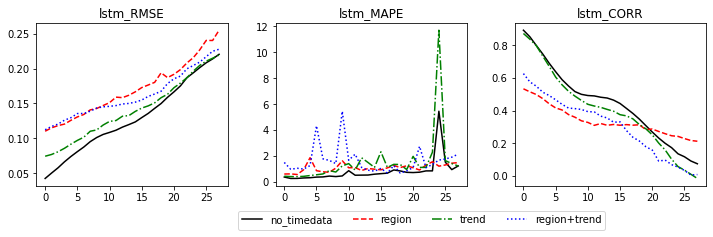

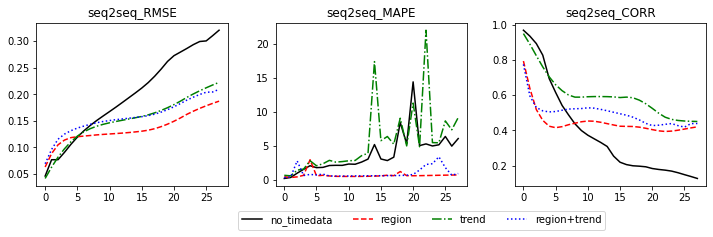

In [55]:
style = {
    'no_timedata' : {'color' : 'black', 'linestyle' : '-'},
    'region' : {'color' : 'red', 'linestyle' : '--'},
    'trend' : {'color' : 'green', 'linestyle' : '-.'},
    'region+trend' : {'color' : 'blue', 'linestyle' : ':'},
}


for model_type in ['lstm', 'seq2seq']:
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    axes[0].set_title(model_type + '_RMSE')
    axes[1].set_title(model_type + '_MAPE')
    axes[2].set_title(model_type + '_CORR')
    
    estms = {}
    for usedData in ['no_timedata', 'region', 'trend', 'region+trend']:
        estms[usedData] = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
    #end for
    
    for usedData in ['no_timedata', 'region', 'trend', 'region+trend']:
        pred_method = model_type + '_' + usedData
        for est_method in ['RMSE', 'MAPE', 'CORR']:
            for state in list(results.keys()):
                vals = results[state][pred_method]['evaluation'][est_method]
                estms[usedData][est_method].append(vals)
            #end for
        #end for
    #end for
    
    for usedData in ['no_timedata', 'region', 'trend', 'region+trend']:
        for i, est_method in enumerate(['RMSE', 'MAPE', 'CORR']):
            avg = np.average(estms[usedData][est_method], axis=0)
            estms[usedData][est_method] = avg
            axes[i].plot(avg, label=usedData, linestyle=style[usedData]['linestyle'], color=style[usedData]['color'])
        #end for
    #end for
    
    plt.legend(ncol=4, bbox_to_anchor=(0.5, -0.3), loc="lower right")
    plt.subplots_adjust(wspace=0.25)
    plt.show()
        

In [73]:
max_week = 4
indexs = []

df = pd.DataFrame(columns=['1-week RMSE', 
                           '1-week MAPE',
                           '1-week CORR',
                           
                           '2-week RMSE', 
                           '2-week MAPE',
                           '2-week CORR',
                           
                           '3-week RMSE', 
                           '3-week MAPE',
                           '3-week CORR',
                          ])

for model_name in ['lstm', 'seq2seq']:
    for timeData in ['no_timedata', 'region', 'trend', 'region+trend']:
        prediction_method = model_name + "_" + timeData
        indexs.append(prediction_method)
        
        estm = {}
        row_data = []
        for week in range(1, max_week + 1):
            estm[str(week) + "_week"] = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
            for state in list(results.keys()):
                for estmate_method in ['RMSE', 'MAPE', 'CORR']:
                    vals = results[state][prediction_method]['evaluation'][estmate_method][week * 7]
                    estm[str(week) + "_week"][estmate_method].append(vals)
                #end for
            #end for
            
            for estmate_method in ['RMSE', 'MAPE', 'CORR']:
                estm[str(week) + "_week"][estmate_method] = np.average(estm[str(week) + "_week"][estmate_method])
                row_data.append(estm[str(week) + "_week"][estmate_method])
            #end for
        #end for
        
        df.loc[len(df)] = row_data
    #end for
#end for


IndexError: list index out of range

## 잘나온거 12개 선정

In [57]:
best12_states = [
    'California',
    'Florida',
    'New York',
    'Texas',
    'Illinois',
    'Pennsylvania',
    'North Carolina',
    'New Jersey',
    'Indiana',
    'Virginia',
    'Louisiana',
    'Wisconsin'
]

In [58]:
best9_states = [
    'California',
    'Florida',
    'New York',
    'Pennsylvania',
    'North Carolina',
    'New Jersey',
    'Indiana',
    'Virginia',
    'Wisconsin'
]

## 잘 나온거 12개 대상으로 한 외부 모델의 예측 결과 불러오기

In [59]:
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

In [60]:
#모델이 테스트 셋에 대하여 예측을 시작한 날짜, 모델이 최대 예측한 날짜
#실제 예측 날짜 구간 2021-09-18   ~   2022-12-31
forecast_start_date = '2021-09-13'
target_end_date = '2022-01-01'

#파일 불러오기
df = pd.read_csv("./data/us_external_model_pred_results.csv")

In [61]:
# 모델 이름들
model_names = list(set(df['forecaster']))

#4주 이상 예측 가능한 모델들만 출력
for name in model_names:
    temp = df[df['forecaster'] == name]
    available_max_step = max(list(set(temp['ahead'])))
    
    #해당 모델이 4스텝 이상 예측 가능한가?
    if available_max_step >= 4:
        print(name)
    #end if
#end for

COVIDhub-baseline
COVIDhub_CDC-ensemble
CovidAnalytics-DELPHI
COVIDhub-ensemble
COVIDhub-4_week_ensemble
BPagano-RtDriven


In [62]:
#모델 선택
model_name = 'CovidAnalytics-DELPHI'
df = pd.read_csv("./data/us_external_model_pred_results.csv")
df = df[df['forecaster'] == model_name]

In [63]:
#주별 전체 평가 
for state in best12_states:
    scaler = MinMaxScaler()
    state_df = df[df['geo_value'] == get_region_code(state).replace('US_', '').lower()]
    scaler = scaler.fit(state_df['actual'].to_numpy().reshape(-1, 1))
    state_df = state_df[(forecast_start_date <= state_df['forecast_date']) & (state_df['target_end_date'] <= target_end_date)]
    
    forecast_dates = pd.DataFrame(list(set(state_df['forecast_date']))).sort_values(by=0)[0].tolist()
    
    targs_final = []
    preds_final = []
    for date in forecast_dates:
        targs = []
        preds = []
        if len(state_df[state_df['forecast_date'] == date]) == 4:
            for step in range(1, 4 + 1):    #step 1 ~ 4
                predTargDf = state_df[state_df['forecast_date'] == date]
                predTargDf = predTargDf[predTargDf['ahead'] == step]
                
                targ = predTargDf.iloc[0]['actual']
                pred = targ - predTargDf.iloc[0]['Score']
                
                targs.append(targ)
                preds.append(pred)
            #end for
            
            targs = np.array(targs)
            preds = np.array(preds)

            targs = scaler.transform(targs.reshape(-1, 1))
            preds = scaler.transform(preds.reshape(-1, 1))
            
            targs = targs.reshape((targs.shape[0], ))
            preds = preds.reshape((preds.shape[0], ))
            
            targs_final.append(targs)
            preds_final.append(preds)
        #end if
    #end for
    
    targs_final = np.array(targs_final)
    preds_final = np.array(preds_final)
    
    results[state][model_name] = {
        'preds' : targs_final,
        'targs' : preds_final,
        'evaluation' : evaluation(preds_final, targs_final, label_width=4)
    }
#end for

## 잘나온거 12개 Seq2Seq

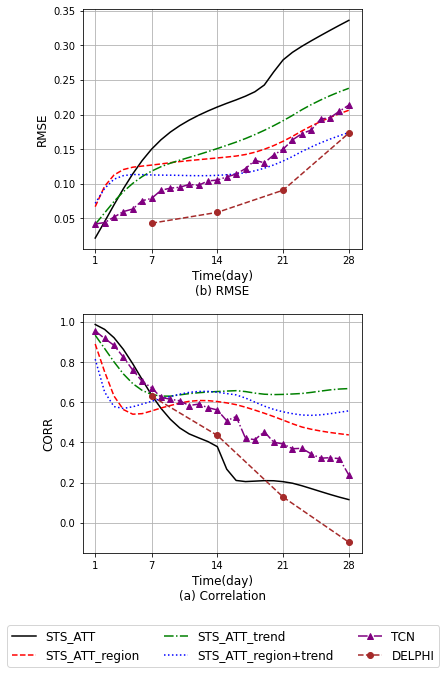

In [94]:
seq2seq_no_timedata = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
seq2seq_region = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
seq2seq_trend = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
seq2seq_both = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}

tcn_no_timedata = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
COVIDhub_no_timedata = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}

#주별 전체 평가 
for state in best9_states:
    seq2seq_no_timedata_estm_rmse = results[state]['seq2seq_no_timedata']['evaluation']['RMSE']
    seq2seq_no_timedata_estm_mape = results[state]['seq2seq_no_timedata']['evaluation']['MAPE']
    seq2seq_no_timedata_estm_corr = results[state]['seq2seq_no_timedata']['evaluation']['CORR']
    seq2seq_no_timedata['RMSE'].append(seq2seq_no_timedata_estm_rmse)
    seq2seq_no_timedata['MAPE'].append(seq2seq_no_timedata_estm_mape)
    seq2seq_no_timedata['CORR'].append(seq2seq_no_timedata_estm_corr)
    
    seq2seq_region_estm_rmse = results[state]['seq2seq_region']['evaluation']['RMSE']
    seq2seq_region_estm_mape = results[state]['seq2seq_region']['evaluation']['MAPE']
    seq2seq_region_estm_corr = results[state]['seq2seq_region']['evaluation']['CORR']
    seq2seq_region['RMSE'].append(seq2seq_region_estm_rmse)
    seq2seq_region['MAPE'].append(seq2seq_region_estm_mape)
    seq2seq_region['CORR'].append(seq2seq_region_estm_corr)
    
    seq2seq_trend_estm_rmse = results[state]['seq2seq_trend']['evaluation']['RMSE']
    seq2seq_trend_estm_mape = results[state]['seq2seq_trend']['evaluation']['MAPE']
    seq2seq_trend_estm_corr = results[state]['seq2seq_trend']['evaluation']['CORR']
    seq2seq_trend['RMSE'].append(seq2seq_trend_estm_rmse)
    seq2seq_trend['MAPE'].append(seq2seq_trend_estm_mape)
    seq2seq_trend['CORR'].append(seq2seq_trend_estm_corr)
    
    seq2seq_both_estm_rmse = results[state]['seq2seq_region+trend']['evaluation']['RMSE']
    seq2seq_both_estm_mape = results[state]['seq2seq_region+trend']['evaluation']['MAPE']
    seq2seq_both_estm_corr = results[state]['seq2seq_region+trend']['evaluation']['CORR']
    seq2seq_both['RMSE'].append(seq2seq_both_estm_rmse)
    seq2seq_both['MAPE'].append(seq2seq_both_estm_mape)
    seq2seq_both['CORR'].append(seq2seq_both_estm_corr)
    
    tcn_estm_rmse = results[state]['tcn']['evaluation']['RMSE']
    tcn_estm_mape = results[state]['tcn']['evaluation']['MAPE']
    tcn_estm_corr = results[state]['tcn']['evaluation']['CORR']
    tcn_no_timedata['RMSE'].append(tcn_estm_rmse)
    tcn_no_timedata['MAPE'].append(tcn_estm_mape)
    tcn_no_timedata['CORR'].append(tcn_estm_corr)
    
    COVIDhub_estm_rmse = results[state][model_name]['evaluation']['RMSE']
    COVIDhub_estm_mape = results[state][model_name]['evaluation']['MAPE']
    COVIDhub_estm_corr = results[state][model_name]['evaluation']['CORR']
    COVIDhub_no_timedata['RMSE'].append(COVIDhub_estm_rmse)
    COVIDhub_no_timedata['MAPE'].append(COVIDhub_estm_mape)
    COVIDhub_no_timedata['CORR'].append(COVIDhub_estm_corr)
#end for

#주별 평균
seq2seq_no_timedata['RMSE'] = np.average(seq2seq_no_timedata['RMSE'], axis=0)
seq2seq_no_timedata['MAPE'] = np.average(seq2seq_no_timedata['MAPE'], axis=0)
seq2seq_no_timedata['CORR'] = np.average(seq2seq_no_timedata['CORR'], axis=0)

seq2seq_region['RMSE'] = np.average(seq2seq_region['RMSE'], axis=0)
seq2seq_region['MAPE'] = np.average(seq2seq_region['MAPE'], axis=0)
seq2seq_region['CORR'] = np.average(seq2seq_region['CORR'], axis=0)

seq2seq_trend['RMSE'] = np.average(seq2seq_trend['RMSE'], axis=0)
seq2seq_trend['MAPE'] = np.average(seq2seq_trend['MAPE'], axis=0)
seq2seq_trend['CORR'] = np.average(seq2seq_trend['CORR'], axis=0)

seq2seq_both['RMSE'] = np.average(seq2seq_both['RMSE'], axis=0)
seq2seq_both['MAPE'] = np.average(seq2seq_both['MAPE'], axis=0)
seq2seq_both['CORR'] = np.average(seq2seq_both['CORR'], axis=0)

tcn_no_timedata['RMSE'] = np.average(tcn_no_timedata['RMSE'], axis=0)
tcn_no_timedata['MAPE'] = np.average(tcn_no_timedata['MAPE'], axis=0)
tcn_no_timedata['CORR'] = np.average(tcn_no_timedata['CORR'], axis=0)

COVIDhub_no_timedata['RMSE'] = np.average(COVIDhub_no_timedata['RMSE'], axis=0)
COVIDhub_no_timedata['MAPE'] = np.average(COVIDhub_no_timedata['MAPE'], axis=0)
COVIDhub_no_timedata['CORR'] = np.average(COVIDhub_no_timedata['CORR'], axis=0)

#그리기
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

axes[0].plot(np.arange(1, 28+1), seq2seq_no_timedata['RMSE'], label='STS_ATT', linestyle="-", color='black')
#axes[1].plot(seq2seq_no_timedata['MAPE'], label='seq2seq_no_timedata', linestyle="-", color='black')
axes[1].plot(np.arange(1, 28+1), seq2seq_no_timedata['CORR'], label='STS_ATT', linestyle="-", color='black')

axes[0].plot(np.arange(1, 28+1), seq2seq_region['RMSE'], label='STS_ATT_region', linestyle="--", color='red')
#axes[1].plot(seq2seq_region['MAPE'], label='seq2seq_region', linestyle="--", color='red')
axes[1].plot(np.arange(1, 28+1), seq2seq_region['CORR'], label='STS_ATT_region', linestyle="--", color='red')

axes[0].plot(np.arange(1, 28+1), seq2seq_trend['RMSE'], label='STS_ATT_trend', linestyle="-.", color='green')
#axes[1].plot(seq2seq_trend['MAPE'], label='seq2seq_trend', linestyle="-.", color='green')
axes[1].plot(np.arange(1, 28+1), seq2seq_trend['CORR'], label='STS_ATT_trend', linestyle="-.", color='green')

axes[0].plot(np.arange(1, 28+1), seq2seq_both['RMSE'], label='STS_ATT_region+trend', linestyle=":", color='blue')
#axes[1].plot(seq2seq_both['MAPE'], label='seq2seq_both', linestyle=":", color='blue')
axes[1].plot(np.arange(1, 28+1), seq2seq_both['CORR'], label='STS_ATT_region+trend', linestyle=":", color='blue')

axes[0].plot(np.arange(1, 28+1), tcn_no_timedata['RMSE'], label='TCN', linestyle="-.", marker='^', color='purple')
#axes[1].plot(tcn_no_timedata['MAPE'], label='tcn', linestyle="-.", color='gray')
axes[1].plot(np.arange(1, 28+1), tcn_no_timedata['CORR'], label='TCN', linestyle="-.", marker='^', color='purple')

axes[0].plot(np.arange(7, 28+1, 7), COVIDhub_no_timedata['RMSE'], label='DELPHI', linestyle="--", marker='o', color='brown')
#axes[1].plot(np.arange(7, 28+1, 7), COVIDhub_no_timedata['MAPE'], label=model_name, linestyle="--", marker='o', color='brown')
axes[1].plot(np.arange(7, 28+1, 7), COVIDhub_no_timedata['CORR'], label='DELPHI', linestyle="--", marker='o', color='brown')

axes[0].set_xlabel('Time(day)\n(b) RMSE', fontsize=12)
axes[1].set_xlabel('Time(day)\n(a) Correlation', fontsize=12)

axes[0].set_ylabel('RMSE', fontsize=12)
axes[1].set_ylabel('CORR', fontsize=12)

axes[0].grid()
axes[1].grid()

axes[0].set_xticks(np.append([1,], np.arange(7, 28+1, 7)), fontsize=12)
axes[1].set_xticks(np.append([1,], np.arange(7, 28+1, 7)), fontsize=12)

plt.legend(ncol=3, bbox_to_anchor=(1.3, -0.5), loc="lower right", fontsize=12)
plt.subplots_adjust(hspace=0.27)
plt.show()

## 잘나온거 12개 표

In [87]:
max_week = 4
indexs = []

df = pd.DataFrame(columns=['1-week RMSE', 
                           '1-week MAPE',
                           '1-week CORR',
                           '2-week RMSE', 
                           '2-week MAPE',
                           '2-week CORR',
                           '3-week RMSE', 
                           '3-week MAPE',
                           '3-week CORR',
                           '4-week RMSE', 
                           '4-week MAPE',
                           '4-week CORR',
                          ])

for model_name in ['lstm', 'seq2seq', 'tcn', 'CovidAnalytics-DELPHI']:
    if ('lstm' in model_name) or ('seq2seq' in model_name):
        for timeData in ['no_timedata', 'region', 'trend', 'region+trend']:
            prediction_method = model_name + "_" + timeData
            indexs.append(prediction_method)

            estm = {}
            row_data = []
            for week in range(1, max_week + 1):
                estm[str(week) + "_week"] = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
                for state in best9_states:
                    for estmate_method in ['RMSE', 'MAPE', 'CORR']:
                        vals = results[state][prediction_method]['evaluation'][estmate_method][7 + (7 * (week - 1)) - 1]
                        estm[str(week) + "_week"][estmate_method].append(vals)
                    #end for
                #end for

                for estmate_method in ['RMSE', 'MAPE', 'CORR']:
                    estm[str(week) + "_week"][estmate_method] = np.average(estm[str(week) + "_week"][estmate_method])
                    row_data.append(estm[str(week) + "_week"][estmate_method])
                #end for
            #end for

            df.loc[len(df)] = row_data
        #end for
    else:
        estm = {}
        row_data = []
        indexs.append(model_name)
        for week in range(1, max_week + 1):
            estm[str(week) + "_week"] = {'RMSE' : [], 'MAPE' : [], 'CORR' : []}
            for state in best9_states:
                for estmate_method in ['RMSE', 'MAPE', 'CORR']:
                    if model_name == 'CovidAnalytics-DELPHI':
                        vals = results[state][model_name]['evaluation'][estmate_method][week - 1]
                    else:
                        vals = results[state][model_name]['evaluation'][estmate_method][7 + (7 * (week - 1)) - 1]
                    #end if
                    estm[str(week) + "_week"][estmate_method].append(vals)
                #end for
            #end for

            for estmate_method in ['RMSE', 'MAPE', 'CORR']:
                estm[str(week) + "_week"][estmate_method] = np.average(estm[str(week) + "_week"][estmate_method])
                row_data.append(estm[str(week) + "_week"][estmate_method])
            #end for
        #end for

        df.loc[len(df)] = row_data
    #end if
#end for


In [88]:
df.index = indexs
df

1-week RMSE  1-week MAPE  1-week CORR  2-week RMSE  \
lstm_no_timedata          0.091484     0.358843     0.592051     0.121465   
lstm_region               0.118005     0.436216     0.336646     0.141494   
lstm_trend                0.113450     0.598858     0.583408     0.141396   
lstm_region+trend         0.129735     1.821645     0.456507     0.133103   
seq2seq_no_timedata       0.149983     1.468239     0.635413     0.210883   
seq2seq_region            0.126982     0.316297     0.556255     0.137278   
seq2seq_trend             0.118290     1.382336     0.638591     0.150882   
seq2seq_region+trend      0.112713     0.402227     0.604509     0.112168   
tcn                       0.078790     0.293073     0.672132     0.105345   
CovidAnalytics-DELPHI     0.043033     1.547910     0.630405     0.058702   

                       2-week MAPE  2-week CORR  3-week RMSE  3-week MAPE  \
lstm_no_timedata          0.494152     0.503323     0.161523     0.597060   
lstm_region               0.626536     0.291254     0.174621     0.663422   
lstm_trend                0.780167     0.403376     0.176979     1.808681   
lstm_region+trend         1.307273     0.480049     0.182114     0.656959   
seq2seq_no_timedata       3.775640     0.378646     0.278906    28.352921   
seq2seq_region            0.339303     0.603298     0.161375     0.405902   
seq2seq_trend             3.961430     0.653094     0.191027    24.425769   
seq2seq_region+trend      0.413415     0.649720     0.132843     0.468492   
tcn                       0.467307     0.561403     0.149943     3.598839   
CovidAnalytics-DELPHI     7.279644     0.434705     0.090743   162.562034   

                       3-week CORR  4-week RMSE  4-week MAPE  4-week CORR  
lstm_no_timedata          0.343384     0.228246     0.949107     0.136684  
lstm_region               0.199097     0.263526     0.901158     0.136851  
lstm_trend                0.186247     0.224468     0.920642     0.049337  
lstm_region+trend         0.176623     0.231219     0.816492     0.076374  
seq2seq_no_timedata       0.204326     0.336024     9.693254     0.114958  
seq2seq_region            0.510846     0.206196     0.557508     0.437160  
seq2seq_trend             0.638746     0.237921    16.040504     0.667726  
seq2seq_region+trend      0.552099     0.173953     0.566424     0.556938  
tcn                       0.392109     0.213630     1.157059     0.237183  
CovidAnalytics-DELPHI     0.127737     0.173126    44.194638    -0.096934

In [89]:
df.to_excel("./table1.xlsx")

## 전체 주 예측 (step 별로 보기)

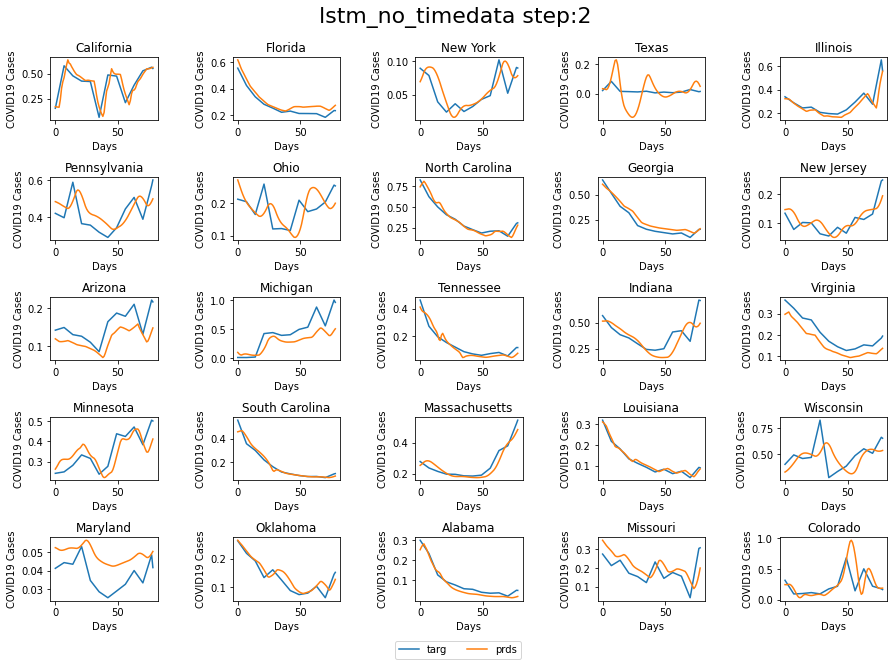

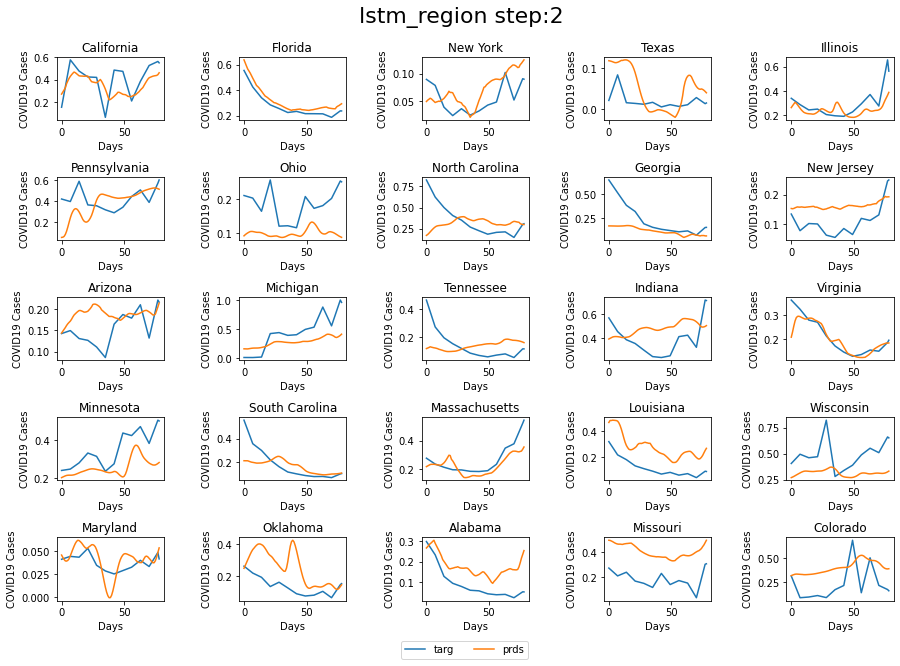

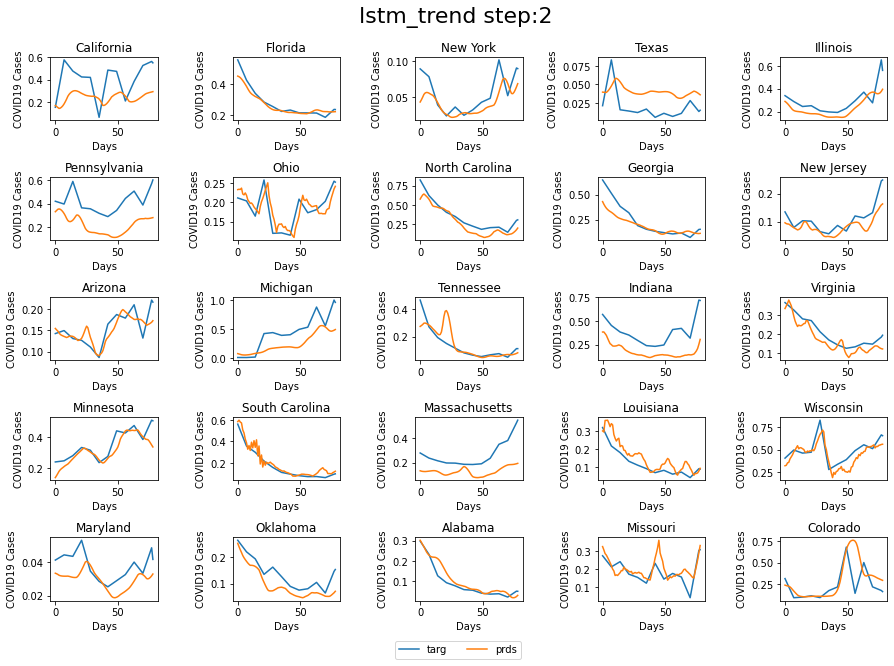

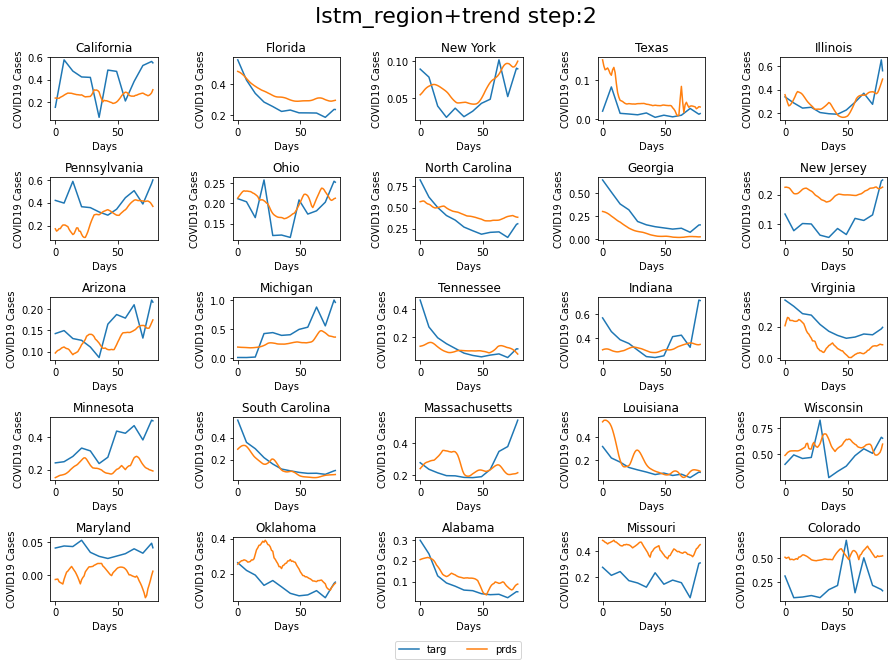

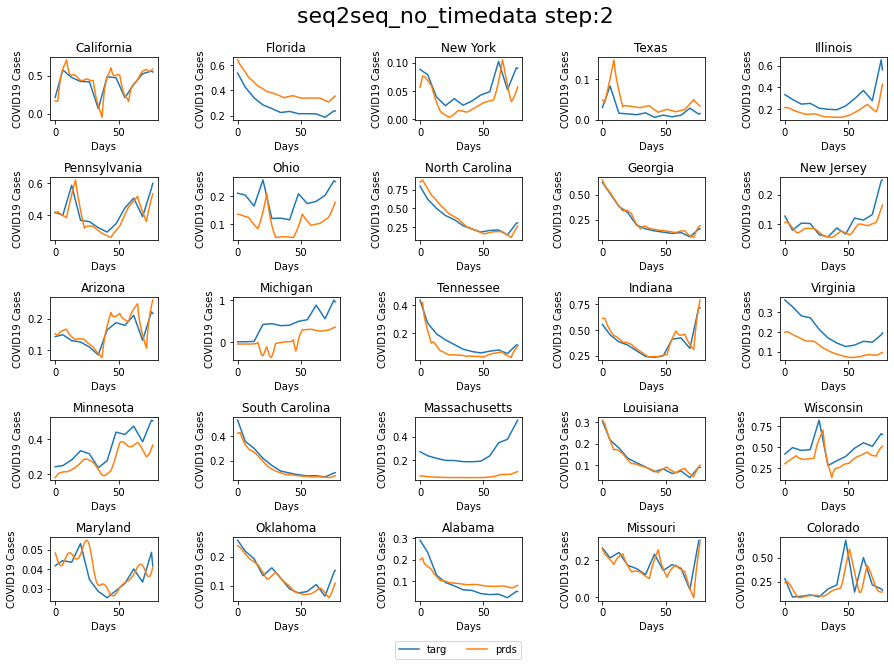

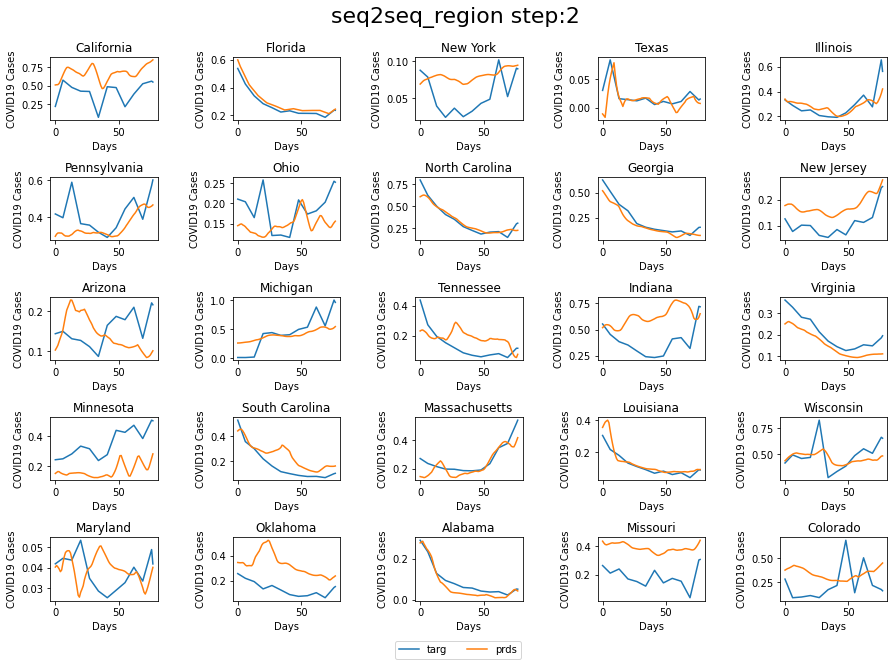

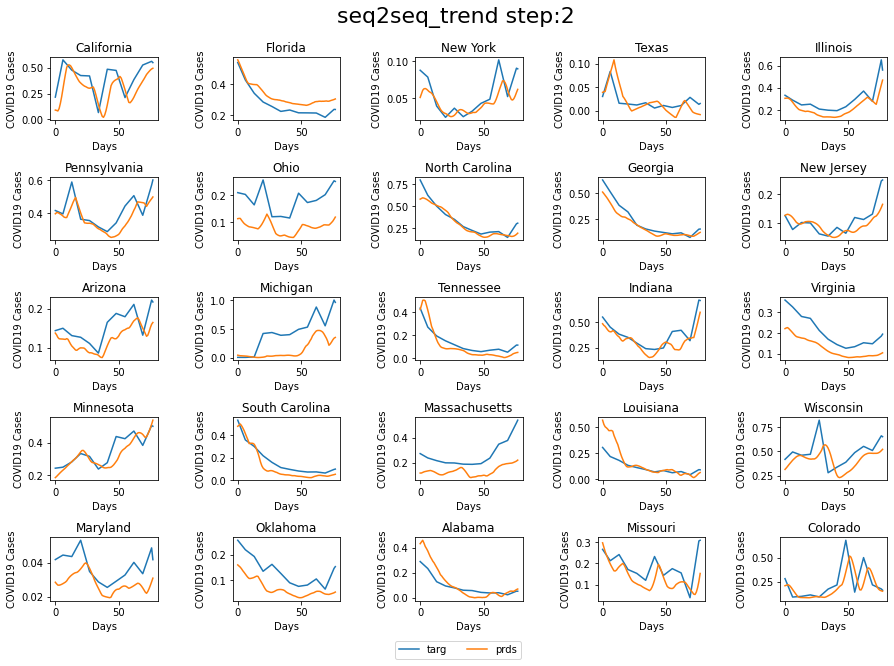

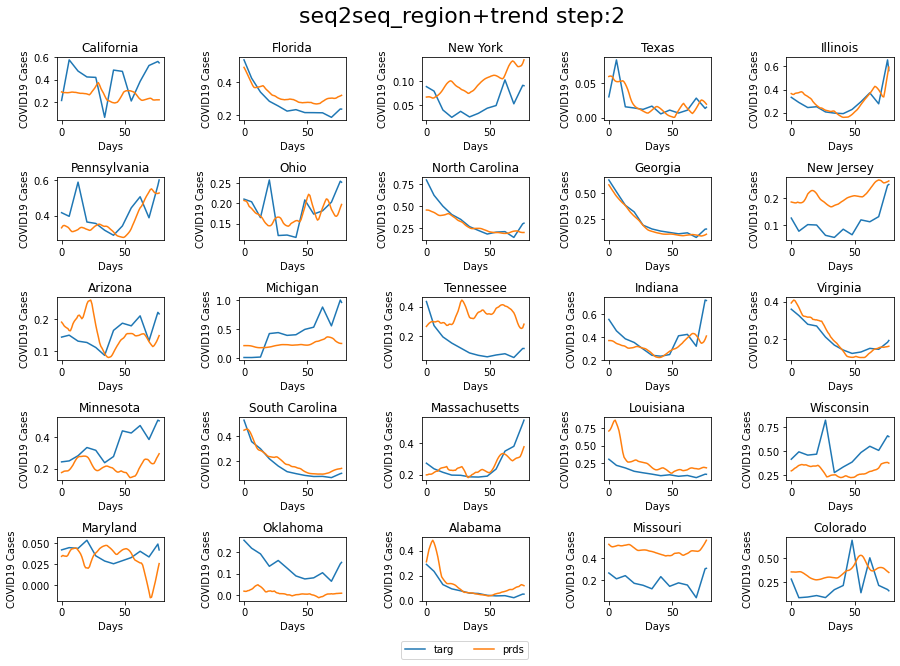

In [69]:
pred_step = 2

target_len = len(target_states.tolist())
row_size = target_len // 5 + int(target_len % 5 != 0)

for model_type in ['lstm', 'seq2seq']:
    for usedData in ['no_timedata', 'region', 'trend', 'region+trend']:
        pred_method = model_type + '_' + usedData
        fig, axs = plt.subplots(row_size, 5, figsize=(15, 2 * row_size))
        figure_text = pred_method + " step:" + str(pred_step)
        fig.text(0.5, 0.95, figure_text, horizontalalignment='center', verticalalignment='top', fontsize=22)
        for i, state in enumerate(target_states):
            p1, = axs[i//5][i%5].plot(results[state][pred_method]['targs'][:, pred_step], label='targ')
            p2, = axs[i//5][i%5].plot(results[state][pred_method]['preds'][:, pred_step], label='pred')

            axs[i//5][i%5].set_title(state)
            axs[i//5][i%5].set_xlabel("Days")
            axs[i//5][i%5].set_ylabel("COVID19 Cases")
        #end for

        plt.subplots_adjust(hspace=0.9, wspace=0.7)
        plt.legend([p1, p2], ['targ', 'prds'], ncol=2, bbox_to_anchor=(-3, -1), loc="lower center")
        plt.show()
    #end for
#end for

## 전체 주 예측 보기

In [70]:
#플롯에 표시할 예측 
show_plots = {
    'seq2seq_no_timedata' : {'style' : {
        'label' : 'STS_ATT',
        'color' : 'black', 
        'linestyle' : '-', 
        'marker' : None,
        'xticks' : np.arange(1, 28+1)
    }},
    'seq2seq_region' : {'style' : {
        'label' : 'STS_ATT_region',
        'color' : 'red', 
        'linestyle' : '--', 
        'marker' : None,
        'xticks' : np.arange(1, 28+1)
    }},
    'seq2seq_trend' : {'style' : {
        'label' : 'STS_ATT_trend',
        'color' : 'green', 
        'linestyle' : '-.', 
        'marker' : None,
        'xticks' : np.arange(1, 28+1)
    }},
    'seq2seq_region+trend' : {'style' : {
        'label' : 'STS_ATT_region+trend',
        'color' : 'blue', 
        'linestyle' : ':', 
        'marker' : None,
        'xticks' : np.arange(1, 28+1)
    }},
    'tcn' : {'style' : {
        'label' : 'TCN',
        'color' : 'purple', 
        'linestyle' : '--', 
        'marker' : '^',
        'xticks' : np.arange(1, 28+1)
    }},
    'CovidAnalytics-DELPHI' : {'style' : {
        'label' : 'DELPHI',
        'color' : 'brown', 
        'linestyle' : '--', 
        'marker' : 'o',
        'xticks' : np.arange(7, 28+1, 7)
    }},
}

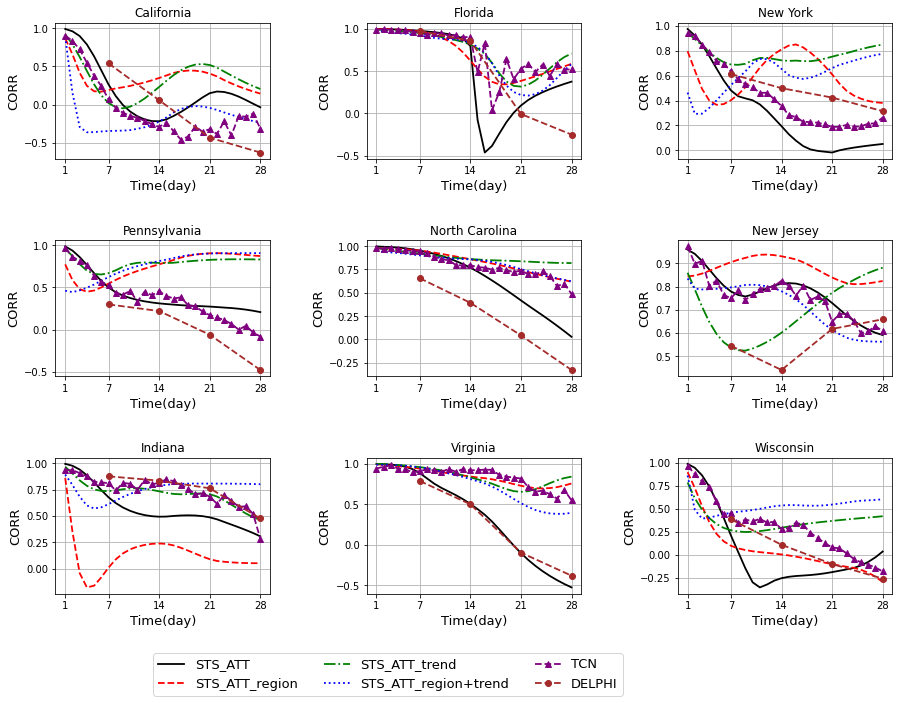

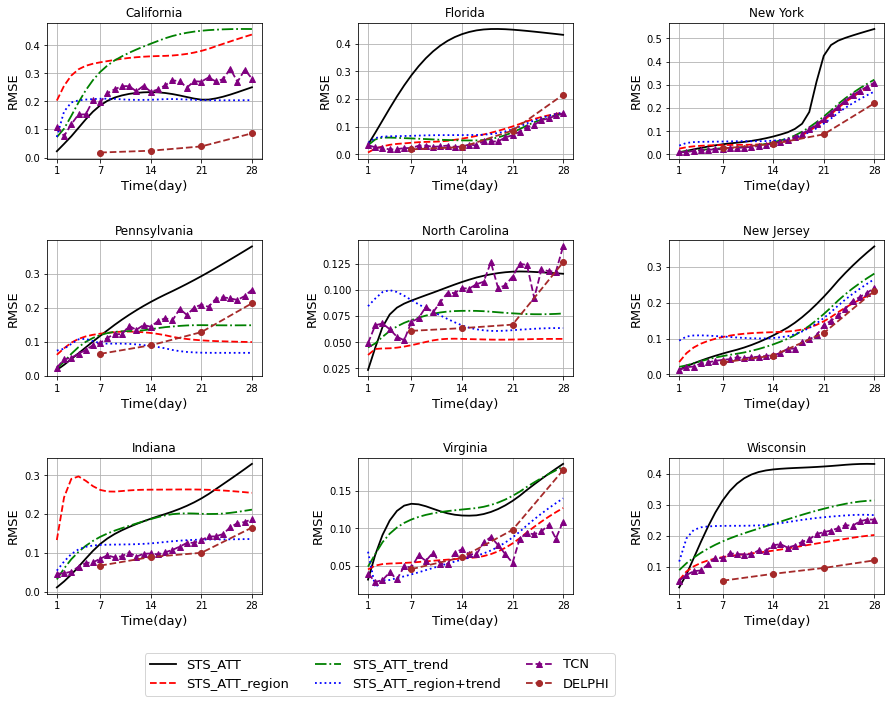

In [71]:
target_len = len(best9_states)
col_size = 3
row_size = (target_len // col_size) + int(target_len % col_size != 0)
del_size = (col_size * row_size) - (target_len)


for estmate_method in ['CORR', 'RMSE']:
    fig, axes = plt.subplots(row_size, col_size, figsize=(45 // col_size, 3.5 * row_size))
    plt.subplots_adjust(wspace=0.45, hspace=0.6)
    
    for i, state in enumerate(best9_states):
        col_cursor = i % col_size
        row_cursor = i // col_size

        plot_lines = []
        for pred_method in list(show_plots.keys()):
            axes[row_cursor][col_cursor].set_title(state)
            line = axes[row_cursor][col_cursor].plot(
                    show_plots[pred_method]['style']['xticks'],
                    results[state][pred_method]['evaluation'][estmate_method],
                    linewidth=1.8,
                    linestyle=show_plots[pred_method]['style']['linestyle'],
                    marker=show_plots[pred_method]['style']['marker'],
                    color=show_plots[pred_method]['style']['color'],
                    label=show_plots[pred_method]['style']['label']
                )
            axes[row_cursor][col_cursor].set_xlabel('Time(day)', fontsize=13)
            axes[row_cursor][col_cursor].set_xticks(np.append([1,], np.arange(7, 28+1, 7)), fontsize=13)
            axes[row_cursor][col_cursor].set_ylabel(estmate_method, fontsize=13)
            axes[row_cursor][col_cursor].grid(True)
            plot_lines.append(line)
        #end for
    plt.legend(ncol=len(list(show_plots.keys())) // 2, bbox_to_anchor=(-(0.45 * col_size), -0.8), loc="lower center", fontsize=13)
    plt.show()
#end for

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


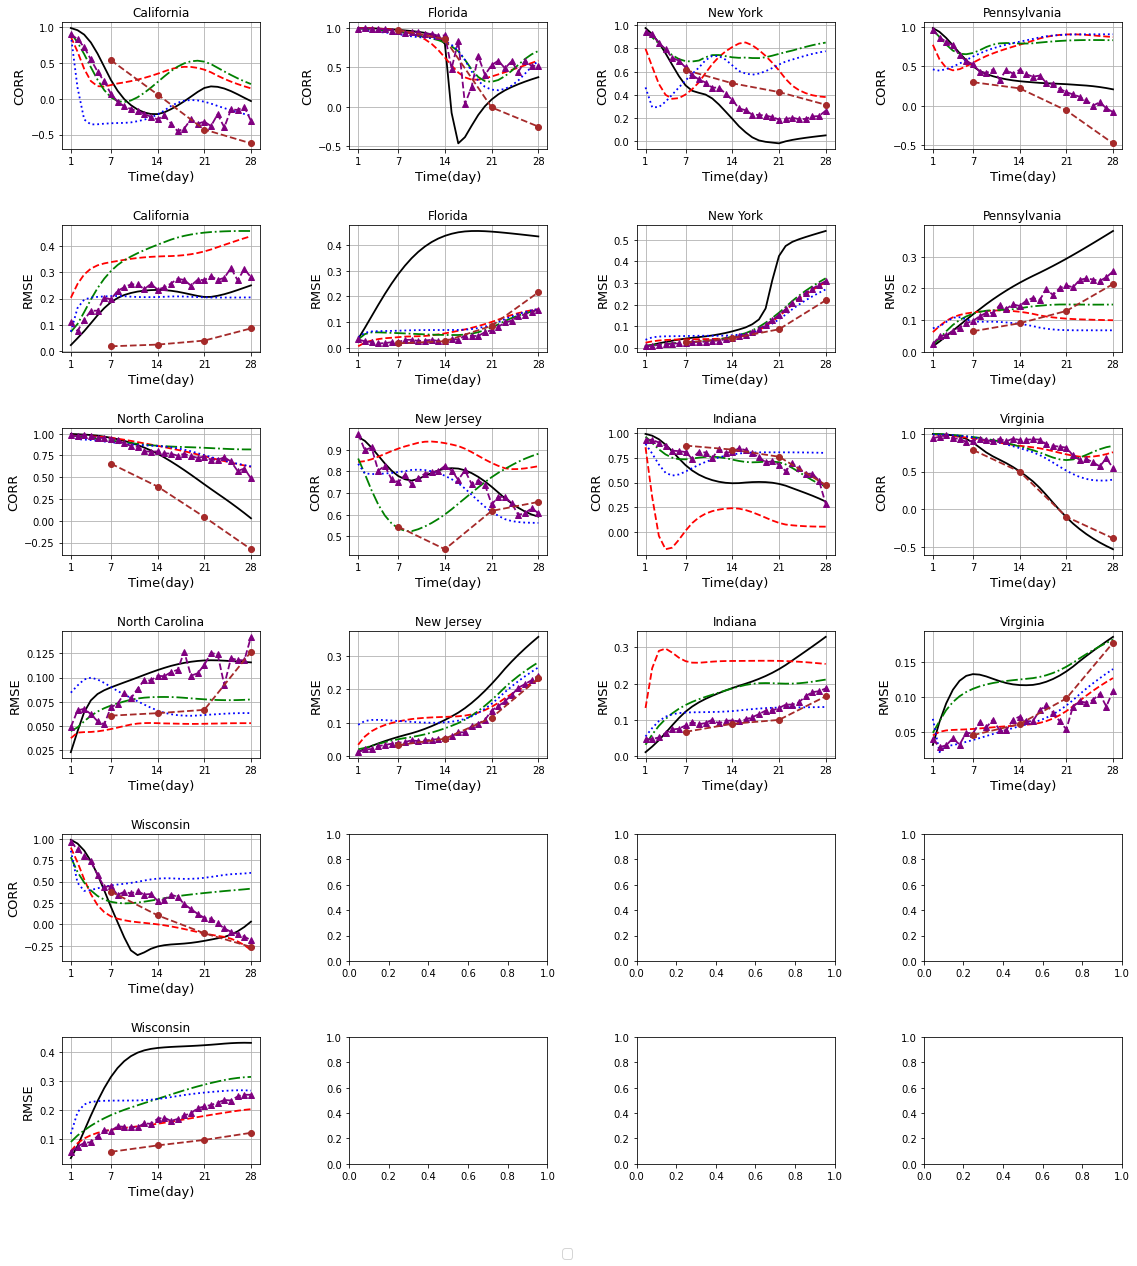

In [72]:
target_len = len(best9_states)
col_size = 4
row_size = ((target_len // col_size) + int(target_len % col_size != 0)) * 2
fig, axes = plt.subplots(row_size, col_size, figsize=(19, 3.5 * row_size))
plt.subplots_adjust(wspace=0.45, hspace=0.6)

for i, state in enumerate(best9_states):
    col_cursor = i % col_size
    row_cursor = (i // col_size) * 2
    
    for j, estmate_method in enumerate(['CORR', 'RMSE']):
        plot_lines = []
        for pred_method in list(show_plots.keys()):
            axes[row_cursor+j][col_cursor].set_title(state)
            line = axes[row_cursor+j][col_cursor].plot(
                show_plots[pred_method]['style']['xticks'],
                results[state][pred_method]['evaluation'][estmate_method],
                linewidth=1.8,
                linestyle=show_plots[pred_method]['style']['linestyle'],
                marker=show_plots[pred_method]['style']['marker'],
                color=show_plots[pred_method]['style']['color'],
                label=show_plots[pred_method]['style']['label']
            )
            axes[row_cursor+j][col_cursor].set_xlabel('Time(day)', fontsize=13)
            axes[row_cursor+j][col_cursor].set_xticks(np.append([1,], np.arange(7, 28+1, 7)), fontsize=13)
            axes[row_cursor+j][col_cursor].set_ylabel(estmate_method, fontsize=13)
            axes[row_cursor+j][col_cursor].grid(True)
            plot_lines.append(line)
        #end for
    #end for
#end for

plt.legend(ncol=len(list(show_plots.keys())) // 2, bbox_to_anchor=(-(0.45 * col_size), -0.8), loc="lower center", fontsize=13)
plt.show()